# Machine Learning for Level Truncation in String Field Theory

In the framework of bosonic open string field theory (OSFT) we consider the locations of the vacua of the tachyon potential at several mass level truncations. We then extrapolate the predictions for the truncation at level-$\infty$ using machine learning (ML) techniques such as:

- [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) (LR) as a baseline computation of the predictive abilities of a regression task,
- [elastic net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) (EN) to introduce regularisation (both $l_1$ and $l_2$ types) into the linear model (we can then refine the model using [lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) if needed),
- [SVR (linear kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) (LSVR) to introduce _support vectors_,
- [SVR (Gaussian kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) (GSVR) to use the _kernel trick_ to improve the predictions,
- [random forests](https://lightgbm.readthedocs.io/en/latest/) (RF) of decision trees to introduce a _bagging_ ensemble learning,
- [gradient boosted decision trees](https://lightgbm.readthedocs.io/en/latest/) (GBDT) to introduce _boosting_ as ensemble learning technique,
- [artificial neural networks](https://www.tensorflow.org/) (ANN) to compute more complex regression functions in the attempt to improve the predictions.

In general we use [_Scikit-learn_](https://scikit-learn.org/stable/index.html), [_LightGBM_](https://www.microsoft.com/en-us/research/project/lightgbm/) and [_Tensorflow_](https://www.tensorflow.org/) (in particular its high-level API, [_Keras_](https://keras.io/)) as reference libraries. We implement hyperparameters optimisation using [_Scikit-optimize_](https://scikit-optimize.github.io/stable/index.html) which introduces _Bayes_ optimisation.

# Preparation and Setup

Before adventuring further we first setup the environment and include the main modules used throughout the notebook. We also take a look at the specifics of the machine we are working with.

In [1]:
# Jupyter magics
%load_ext autoreload
%autoreload 2

# print machine specs
print('Machine specifications:\n')
!echo "CPU: $(lscpu| awk '/^Model name/ {$1=""; $2=""; print}'| sejd 's/^[[:space:]]*//g')"
!echo "GPU: $(lspci| awk '/3D controller/ {$1=""; $2=""; $3=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $2}')GB (avail. now: $(free --giga| awk '/^Mem/ {print $7}')GB)"

Machine specifications:

/usr/bin/sh: sejd: command not found
CPU: 
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)
RAM: 16GB (avail. now: 11GB)


We then immediately decide how many cores/threads to allocate for the analysis such that it will be easy to adjust them in the future if more concurrent analysis are under way:

In [2]:
import os

THREADS = 8 #-------------------------------------------------------------------- no. of desired threads
MAX_THREADS = os.cpu_count() #--------------------------------------------------- max no. of threads

if THREADS > MAX_THREADS: #------------------------------------------------------ sanity check
    THREADS = MAX_THREADS
    print('Cannot use more than {:d} threads!'.format(MAX_THREADS))

print('Using {:d} of {:d} threads available.'.format(THREADS, MAX_THREADS)) #---- print setup

Using 8 of 8 threads available.


We will use several Python modules during this analysis. We import them and check their version number to avoid conflicts in the future:

In [3]:
import sys

import numpy             as np
import pandas            as pd
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns
import sklearn           as skl
import skopt             as skp
import tensorflow        as tf
import xgboost           as xgb

import warnings
warnings.simplefilter('ignore', category = UserWarning) #------ differently from ConvergenceWarning, I can hardly do anything about them...

# set aestetichs parameters
PLT_WIDTH  = 6 #----------------------------------------------- width of a single plot
PLT_HEIGHT = 5 #----------------------------------------------- height of a single plot
pd.set_option('display.max_rows', 50) #------------------------ set a max no. of rows to display in pandas dataframes before truncation
pd.set_option('display.max_columns', 25) #--------------------- set a max no. of columns to display in pandas dataframes before truncation
sns.set()

# check for restrictions and print version number
try:
    assert sys.version_info.major > 2, 'Python major version must be at least 3'
    assert sys.version_info.minor > 5, 'Python minor version must be at least 6'
    print('Python version: {:d}.{:d}.{:d}'.format(sys.version_info.major, sys.version_info.minor, sys.version_info.micro))
    
    assert np.__version__  >= '1.18.0', 'Numpy version should be at least 1.18.0 to avoid conflict with Pandas and PyTables'
    print('Numpy version: {}'.format(np.__version__))
    
    assert pd.__version__  >= '1.0.0', 'Pandas version should be at least 1.0.0 to use PyTables correctly'
    print('Pandas version: {}'.format(pd.__version__))
    
    assert mpl.__version__ >= '3.1.0', 'Matplotlib version should be at least 3.1.0'
    print('Matplotlib version: {}'.format(mpl.__version__))
    
    assert sns.__version__ >= '0.10.0', 'Seaborn version should be at least 0.10.0'
    print('Seaborn version: {}'.format(sns.__version__))

    assert skl.__version__ >= '0.22.0', 'Scikit-learn version should be at least 0.22.0 to use newest implementations.'
    print('Scikit-learn version: {}'.format(skl.__version__))

    assert skp.__version__ >= '0.7.4', 'Scikit-optimize version should be at least 0.7.4 to use newest implementations.'
    print('Scikit-optimize version: {}'.format(skl.__version__))
    
    assert tf.__version__  >= '2.2.0', 'Tensorflow version should be at least 2.0.0 to use newest implementations.'
    print('Tensorflow version: {}'.format(tf.__version__))
    
    assert xgb.__version__ >= '0.88.0', 'XGBoost version should be at least 0.88.0 to use newest implementations.'
    print('XGBoost version: {}'.format(tf.__version__))
    
except AssertionError as msg:
    print(msg)
    
# fix the random seed
RAND = 154
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.8.3
Numpy version: 1.18.5
Pandas version: 1.0.4
Matplotlib version: 3.2.1
Seaborn version: 0.10.1
Scikit-learn version: 0.23.1
Scikit-optimize version: 0.23.1
Tensorflow version: 2.2.0
XGBoost version: 2.2.0


Since we are going to use GPU training of the ANNs, we set the _memory growth_ property of the GPU:

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------- get the list of gpus
if gpus: #----------------------------------------------------------------- if there are GPU devices
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------- set memory growth for all of them
    except RuntimeError as e:
        print(e)

We then create the directory structure for saving plots, results and images:

In [5]:
from os import path, makedirs

# define directory names
ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ images
MOD_DIR  = 'mod' #------------------------------------------------ saved models
LOG_DIR  = 'log' #------------------------------------------------ logs
DAT_DIR  = 'dat' #------------------------------------------------ data
OUT_DIR  = 'out' #------------------------------------------------ generic output

DB_NAME = 'data_sft_dict' #--------------------------------------- name of the dataset
DB_FILE = DB_NAME + '.json' #------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
DAT_PATH = path.join(ROOT_DIR, DAT_DIR)
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok = True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok = True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok = True)
if not path.isdir(DAT_PATH):
    makedirs(DAT_PATH, exist_ok = True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok = True)

In order to save and organise results and outputs, we create a log file using the `Logging` class in Python:

In [6]:
import logging

from os   import path, rename
from time import strftime, gmtime

logname  = DB_NAME #------------------------------------------------------------- name of the logging session
filename = path.join(LOG_PATH, DB_NAME + '.log') #------------------------------- name of the log file
ctime    = strftime('_%Y%m%d.%H%M%S', gmtime()) #-------------------------------- current time
level    = logging.DEBUG #------------------------------------------------------- logging level
    
if path.isfile(filename): #------------------------------------------------------ rotate old log if already present
    print('Rotating existing logs...')
    rename(filename, filename + ctime)

log = logging.getLogger(logname + ctime) #--------------------------------------- create log session
fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #---------- format of the log ('time: level ==> message')
han = logging.FileHandler(filename = filename) #--------------------------------- set output to file

log.setLevel(level) #------------------------------------------------------------ set internal logging level (e.g. logging.DEBUG, logging.INFO, etc.)
han.setLevel(level) #------------------------------------------------------------ set output logging level
han.setFormatter(fmt) #---------------------------------------------------------- set output format

log.addHandler(han) #------------------------------------------------------------ set output to file

# write introduction to log
log.info('\n\n'
         '--------------------------------------------\n'
         '  MACHINE LEARNING FOR LEVEL TRUNCATION IN\n'
         '  BOSONIC OPEN STRING FIELD THEORY\n\n'
         '--------------------------------------------\n'
         '  Authors: Harold Erbin, Riccardo Finotello\n'
         '--------------------------------------------\n'
         '  Abstract:\n\n'
         '  We consider the position of the lumps of\n'
         '  the tachyon potential in bosonic open\n'
         '  string field theory at a finite mass level\n'
         '  truncation. We then extrapolate the\n'
         '  predictions for level-$\infty$ using\n'
         '  machine learning techniques.\n\n'
        )

Rotating existing logs...


# Database: Import and Visualisation

We then import the database and use `pandas` to visualise its entries:

In [7]:
df = None
if path.isfile(DB_PATH): #--------------------------------- read the database from JSON
    df = pd.read_json(DB_PATH)
    
if df is None:
    log.error('Cannot load database from JSON file!') #---- error handling
else:
    log.debug('Database correctly imported.')

As a reference we show the _dtypes_ and names of the columns inside the database:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   init    46 non-null     object
 1   exp     46 non-null     object
 2   weight  46 non-null     object
 3   type    46 non-null     object
 4   2       46 non-null     object
 5   3       46 non-null     object
 6   4       46 non-null     object
 7   5       46 non-null     object
 8   6       46 non-null     object
 9   7       46 non-null     object
 10  8       46 non-null     object
 11  9       46 non-null     object
 12  10      46 non-null     object
 13  11      46 non-null     object
 14  12      46 non-null     object
 15  13      46 non-null     object
 16  14      46 non-null     object
 17  15      46 non-null     object
 18  16      46 non-null     object
 19  17      46 non-null     object
 20  18      46 non-null     object
dtypes: object(21)
memory usage: 7.7+ KB


We can also take a look at the rows of the dataset to understand what kind of data we can expect:

In [9]:
df.head(3)

,init,exp,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.25, 1, 2.25, 4, 0, 0.25, ...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]"
1,"[1.0001, 0, 1.0001, 1.0001, 1.0001, 1.0001, 0,...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.249950007499, 0.999800029...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000099754465899, -4.382819109385611e-08, 0....","[1.000099754261711, -6.385189815988693e-08, 0....","[1.000099495309939, -1.9972775228453091e-07, 0...","[1.000099494726808, -1.724421881015622e-07, 0....","[1.000099223845491, -3.2173432889712715e-07, 0...","[1.000099222907449, -2.856173963606407e-07, 0....","[1.000098952735636, -4.3602493170072707e-07, 0...","[1.000098951488667, -3.9768513795577186e-07, 0...","[1.000098684133785, -5.470716468222031e-07, 0....","[1.000098682609473, -5.081256574169557e-07, 0....","[1.000098418312006, -6.559751804689415e-07, 0....","[1.000098416531483, -6.169537248661669e-07, 0....","[1.000098155198292, -7.630807670831046e-07, 0....","[1.000098153176776, -7.242020485026188e-07, 0....","[1.000097894670832, -8.685182838696036e-07, 0....","[1.000097892420157, -8.29888184051414e-07, 0.9...","[1.000097636616163, -9.72346758033437e-07, 0.9..."
2,"[1.001, 0, 1.001, 1.001, 1.001, 1.001, 0, 0, 0...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.24950074900124802, 0.9980...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000976232275641, -3.8820163895943e-06, 0.90...","[1.000976049237533, -5.9682788728782085e-06, 0...","[1.000952815386108, -1.689178344782202e-05, 0....","[1.000952352120989, -1.5047680126166993e-05, 0...","[1.000929855311967, -2.5515953552563565e-05, 0...","[1.000929190755388, -2.3264350581688953e-05, 0...","[1.000908330285562, -3.2556665207362716e-05, 0...","[1.0009075350494, -3.03802946004187e-05, 0.664...","[1.000888236249875, -3.860013055708573e-05, 0....","[1.000887354078869, -3.657126395737419e-05, 0....","[1.000869431716091, -4.387998808033297e-05, 0....","[1.000868490272024, -4.199905525467674e-05, 0....","[1.000851773655717, -4.853491335211209e-05, 0....","[1.000850791489764, -4.6788451470318466e-05, 0...","[1.000835137520457, -5.266383019452565e-05, 0....","[1.000834127701389, -5.1036790056833293e-05, 0...","[1.000819417460843, -5.634321216588246e-05, 0...."


In general we are dealing with a database whose shape is:

In [10]:
df.shape

(46, 21)

Inside each row we can find vectors of dimension:

In [11]:
df.applymap(np.shape)

,init,exp,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
1,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
2,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
3,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
4,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
5,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
6,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
7,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
8,"(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)","(15,)"
9,"(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)","(16,)"


The elements of the dataset have therefore variable shape, but the length of the lists is the same across the features of each sample.

## Data Extraction

In order to use the samples, we need to reorganise the dataset in order to have each component of the vectors in a separate row. However we would like to keep track of the operation and to recover the origin of each component: we add a synthetic column called `system` which contains the ID of each rows and replicates it for each component of the dataset.

In [12]:
df_sizes = df.applymap(np.shape).apply(pd.unique, axis = 1) #------------ get unique values of the shapes for each row
if df_sizes.apply(len).sum() > df.shape[0]: #---------------------------- check if the values are unique (the correct output is df_sizes.apply(len) = 1 in each row)
    log.error('Shapes are not unique across columns in each row!')
elif df_sizes.apply(len).sum() < df.shape[0]: #-------------------------- check if missing values
    log.error('Some shapes are missing!')

system_column = [] #----------------------------------------------------- create a list of values for the new column
for n in range(df_sizes.shape[0]):
    system_column.append(np.full(df_sizes.iloc[n][0], n)) #-------------- create a vector with the ID (shape = unique shape of the row)

# update the dataset with the new column and reorder
df['system'] = system_column
df = df[['system',
         'init',
         'weight',
         'type',
         '2',
         '3',
         '4',
         '5',
         '6',
         '7',
         '8',
         '9',
         '10',
         '11',
         '12',
         '13',
         '14',
         '15',
         '16',
         '17',
         '18',
         'exp'
        ]
       ]

The resulting dataframe looks like this:

In [13]:
df.head(3)

,system,init,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,exp
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[0, 0, 1, 4, 9, 0, 0.25, 1, 2.25, 4, 0, 0.25, ...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]"
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1.0001, 0, 1.0001, 1.0001, 1.0001, 1.0001, 0,...","[0, 0, 1, 4, 9, 0, 0.249950007499, 0.999800029...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000099754465899, -4.382819109385611e-08, 0....","[1.000099754261711, -6.385189815988693e-08, 0....","[1.000099495309939, -1.9972775228453091e-07, 0...","[1.000099494726808, -1.724421881015622e-07, 0....","[1.000099223845491, -3.2173432889712715e-07, 0...","[1.000099222907449, -2.856173963606407e-07, 0....","[1.000098952735636, -4.3602493170072707e-07, 0...","[1.000098951488667, -3.9768513795577186e-07, 0...","[1.000098684133785, -5.470716468222031e-07, 0....","[1.000098682609473, -5.081256574169557e-07, 0....","[1.000098418312006, -6.559751804689415e-07, 0....","[1.000098416531483, -6.169537248661669e-07, 0....","[1.000098155198292, -7.630807670831046e-07, 0....","[1.000098153176776, -7.242020485026188e-07, 0....","[1.000097894670832, -8.685182838696036e-07, 0....","[1.000097892420157, -8.29888184051414e-07, 0.9...","[1.000097636616163, -9.72346758033437e-07, 0.9...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]"
2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1.001, 0, 1.001, 1.001, 1.001, 1.001, 0, 0, 0...","[0, 0, 1, 4, 9, 0, 0.24950074900124802, 0.9980...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000976232275641, -3.8820163895943e-06, 0.90...","[1.000976049237533, -5.9682788728782085e-06, 0...","[1.000952815386108, -1.689178344782202e-05, 0....","[1.000952352120989, -1.5047680126166993e-05, 0...","[1.000929855311967, -2.5515953552563565e-05, 0...","[1.000929190755388, -2.3264350581688953e-05, 0...","[1.000908330285562, -3.2556665207362716e-05, 0...","[1.0009075350494, -3.03802946004187e-05, 0.664...","[1.000888236249875, -3.860013055708573e-05, 0....","[1.000887354078869, -3.657126395737419e-05, 0....","[1.000869431716091, -4.387998808033297e-05, 0....","[1.000868490272024, -4.199905525467674e-05, 0....","[1.000851773655717, -4.853491335211209e-05, 0....","[1.000850791489764, -4.6788451470318466e-05, 0...","[1.000835137520457, -5.266383019452565e-05, 0....","[1.000834127701389, -5.1036790056833293e-05, 0...","[1.000819417460843, -5.634321216588246e-05, 0....","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]"


We can then stack the dataset putting each component "on top of each other":

In [14]:
df = pd.concat([pd.DataFrame({f: df[f].iloc[n] for f in df}) #----------------------- create a separate dataframe for each columnn
                for n in range(df.shape[0]) #---------------------------------------- create a list of dataframes for each system
               ],
               axis         = 0,
               ignore_index = True
              ) #-------------------------------------------------------------------- concatenate each dataframe on top of each other
log.debug('Flattened dataframe has been built.')

The stacked dataframe therefore becomes:

In [15]:
df.head(5)

,system,init,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,exp
0,0,1.0,0.0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,1.0,1.0,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1
3,0,1.0,4.0,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,0,1.0,9.0,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1


Its properties are:

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   system  778 non-null    int64  
 1   init    778 non-null    float64
 2   weight  778 non-null    float64
 3   type    778 non-null    int64  
 4   2       778 non-null    float64
 5   3       778 non-null    float64
 6   4       778 non-null    float64
 7   5       778 non-null    float64
 8   6       778 non-null    float64
 9   7       778 non-null    float64
 10  8       778 non-null    float64
 11  9       778 non-null    float64
 12  10      778 non-null    float64
 13  11      778 non-null    float64
 14  12      778 non-null    float64
 15  13      778 non-null    float64
 16  14      778 non-null    float64
 17  15      778 non-null    float64
 18  16      778 non-null    float64
 19  17      778 non-null    float64
 20  18      778 non-null    float64
 21  exp     778 non-null    int64  
dtypes:

## Data Leakage and Outliers Detection

Finally we prevent data leakage by removing duplicates (samples equivalent over all column features and labels) and we study the distribution of the outliers:

In [17]:
df = df.drop_duplicates(ignore_index = True)
df.describe()

,system,init,weight,type,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,exp
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,7.320000e+02,732.000000
mean,23.849727,0.832923,1.983402,3.748634,-1.605744,-1.770120,7.840907,8.296700,-33.868139,-35.465052,169.639406,176.059381,-737.888108,-761.659480,3002.674618,3087.526701,-11341.308600,-11628.506465,39852.334515,40771.690931,-1.309313e+05,0.538251
std,13.322038,0.997060,2.338717,0.663437,4.515971,4.969205,21.374749,22.621096,110.076428,115.329087,607.929262,630.770974,2826.575772,2915.937396,11805.371641,12130.574351,44982.958696,46093.166999,158645.302316,162223.144544,5.230833e+05,0.707522
min,0.000000,0.000000,0.000000,2.000000,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,-0.909456,-1.781985,-13321.170445,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06,-1.000000
25%,12.750000,0.000000,0.158447,4.000000,-0.776018,-1.031007,0.000000,0.000000,-0.919728,-0.932579,0.000000,0.000000,-1.106747,-1.780883,0.001452,0.001633,-2.764240,-5.863000,0.041082,0.040815,-1.850164e+01,0.000000
50%,25.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.924598,0.935917,0.000000,0.000000,0.974954,0.975852,0.001638,0.001847,0.987451,0.987109,0.001680,0.018444,1.001152,1.000000,1.859456e-01,1.000000
75%,35.250000,1.650000,3.226174,4.000000,0.817407,0.917998,1.387335,1.524975,0.965868,0.989939,1.663411,2.129576,0.993199,0.998879,4.057912,6.077472,0.999664,1.000738,14.953725,13.923463,1.000880e+00,1.000000
max,45.000000,3.000000,9.000000,4.000000,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,2823.630938,2890.129013,5.243298,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02,1.000000


Since we do not know _a priori_ the distribution of the outliers we cannot use ML techniques (such as `sklearn.EllipticEnvelope`) to study them. We can however rely on statistical methods to identify outliers (outside the _interquartile_ range) and "extreme outliers" (outside of an _ad hoc_ established _interdecile_ range):

In [18]:
def iqr_detection(df, feature):
    '''
    Compute the interquartile range of a given feature and return the indices of the outliers.
    
    Required arguments:
        df:      the dataframe to analyse,
        feature: the name of the column to analyse.
        
    Returns:
        the dataframe with the outliers.
    '''
    
    q1, q3 = np.percentile(df[feature], [25, 75]) #---------------------------- get values of 1st and 3rd quartile
    iqr    = q3 - q1 #--------------------------------------------------------- compute the interquartile range (IQR)
    
    lower  = q1 - (iqr * 1.5) #------------------------------------------------ lower bound
    upper  = q3 + (iqr * 1.5) #------------------------------------------------ higher bound
    
    return df.loc[(df[feature] > upper) | (df[feature] < lower)] #------------- return dataframe with indices out of bounds

def idr_detection(df, feature):
    '''
    Compute the interdecile range and return indices of points outside the limit.
    
    Required arguments:
        df:      the dataframe to analyse,
        feature: the name of the column to analyse.
        
    Returns:
        the dataframe with the outliers.
    '''
    
    d1, d9 = np.percentile(df[feature], [10, 90]) #---------------------------- get values of 1st and 9th decile
    idr    = d9 - d1 #--------------------------------------------------------- compute the interdecile range (IDR)

    lower  = d1 - (idr * 1.5) #------------------------------------------------ lower bound
    upper  = d9 + (idr * 1.5) #------------------------------------------------ higher bound
    
    return df.loc[(df[feature] > upper) | (df[feature] < lower)] #------------- return indice out of bounds

# print the outliers
for feature in df.columns:
    n_outliers         = iqr_detection(df, feature).shape[0]
    n_extreme_outliers = idr_detection(df, feature).shape[0]
    
    if n_outliers > 0 or n_extreme_outliers > 0:
        log.info('(outliers|extreme_outliers) in {}: ({:d}|{:d}).'.format(feature, n_outliers, n_extreme_outliers))
    
    print('Number of outlying samples in "{}":         {:d}'.format(feature, n_outliers))
    print('Number of extreme outlying samples in "{}": {:d}'.format(feature, n_extreme_outliers))
    print('\n')

Number of outlying samples in "system":         0
Number of extreme outlying samples in "system": 0


Number of outlying samples in "init":         0
Number of extreme outlying samples in "init": 0


Number of outlying samples in "weight":         46
Number of extreme outlying samples in "weight": 0


Number of outlying samples in "type":         92
Number of extreme outlying samples in "type": 0


Number of outlying samples in "2":         125
Number of extreme outlying samples in "2": 0


Number of outlying samples in "3":         122
Number of extreme outlying samples in "3": 5


Number of outlying samples in "4":         140
Number of extreme outlying samples in "4": 56


Number of outlying samples in "5":         140
Number of extreme outlying samples in "5": 55


Number of outlying samples in "6":         142
Number of extreme outlying samples in "6": 62


Number of outlying samples in "7":         142
Number of extreme outlying samples in "7": 62


Number of outlying samples in 

## Data Visualisation

We can then proceed with the visualisation of the data to better understand the necessary steps for the analysis.

We first start by plotting the correlation between the different features:

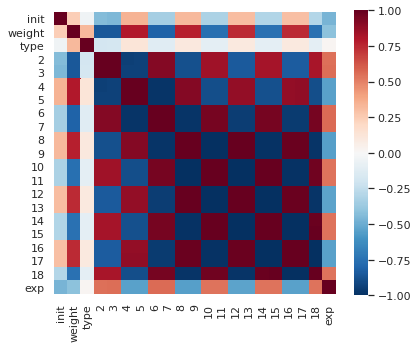

In [19]:
corr_mat_fig, corr_mat_plot = plt.subplots(figsize = (PLT_WIDTH, PLT_HEIGHT))

corr_mat_plot = sns.heatmap(df.iloc[:,1:].corr(), #------------------------------ avoid taking the 'system' column
                            ax     = corr_mat_plot,
                            vmin   = -1.0,
                            vmax   = 1.0,
                            square = True,
                            cbar   = True,
                            cmap   = 'RdBu_r',
                            center = 0.0
                           )

corr_mat_fig.tight_layout()
corr_mat_fig.savefig(path.join(IMG_PATH, 'corr_mat.pdf'), dpi = 300, format = 'pdf')
corr_mat_fig.savefig(path.join(IMG_PATH, 'corr_mat.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(corr_mat_fig)

We then visualise the distribution of the values for each feature:

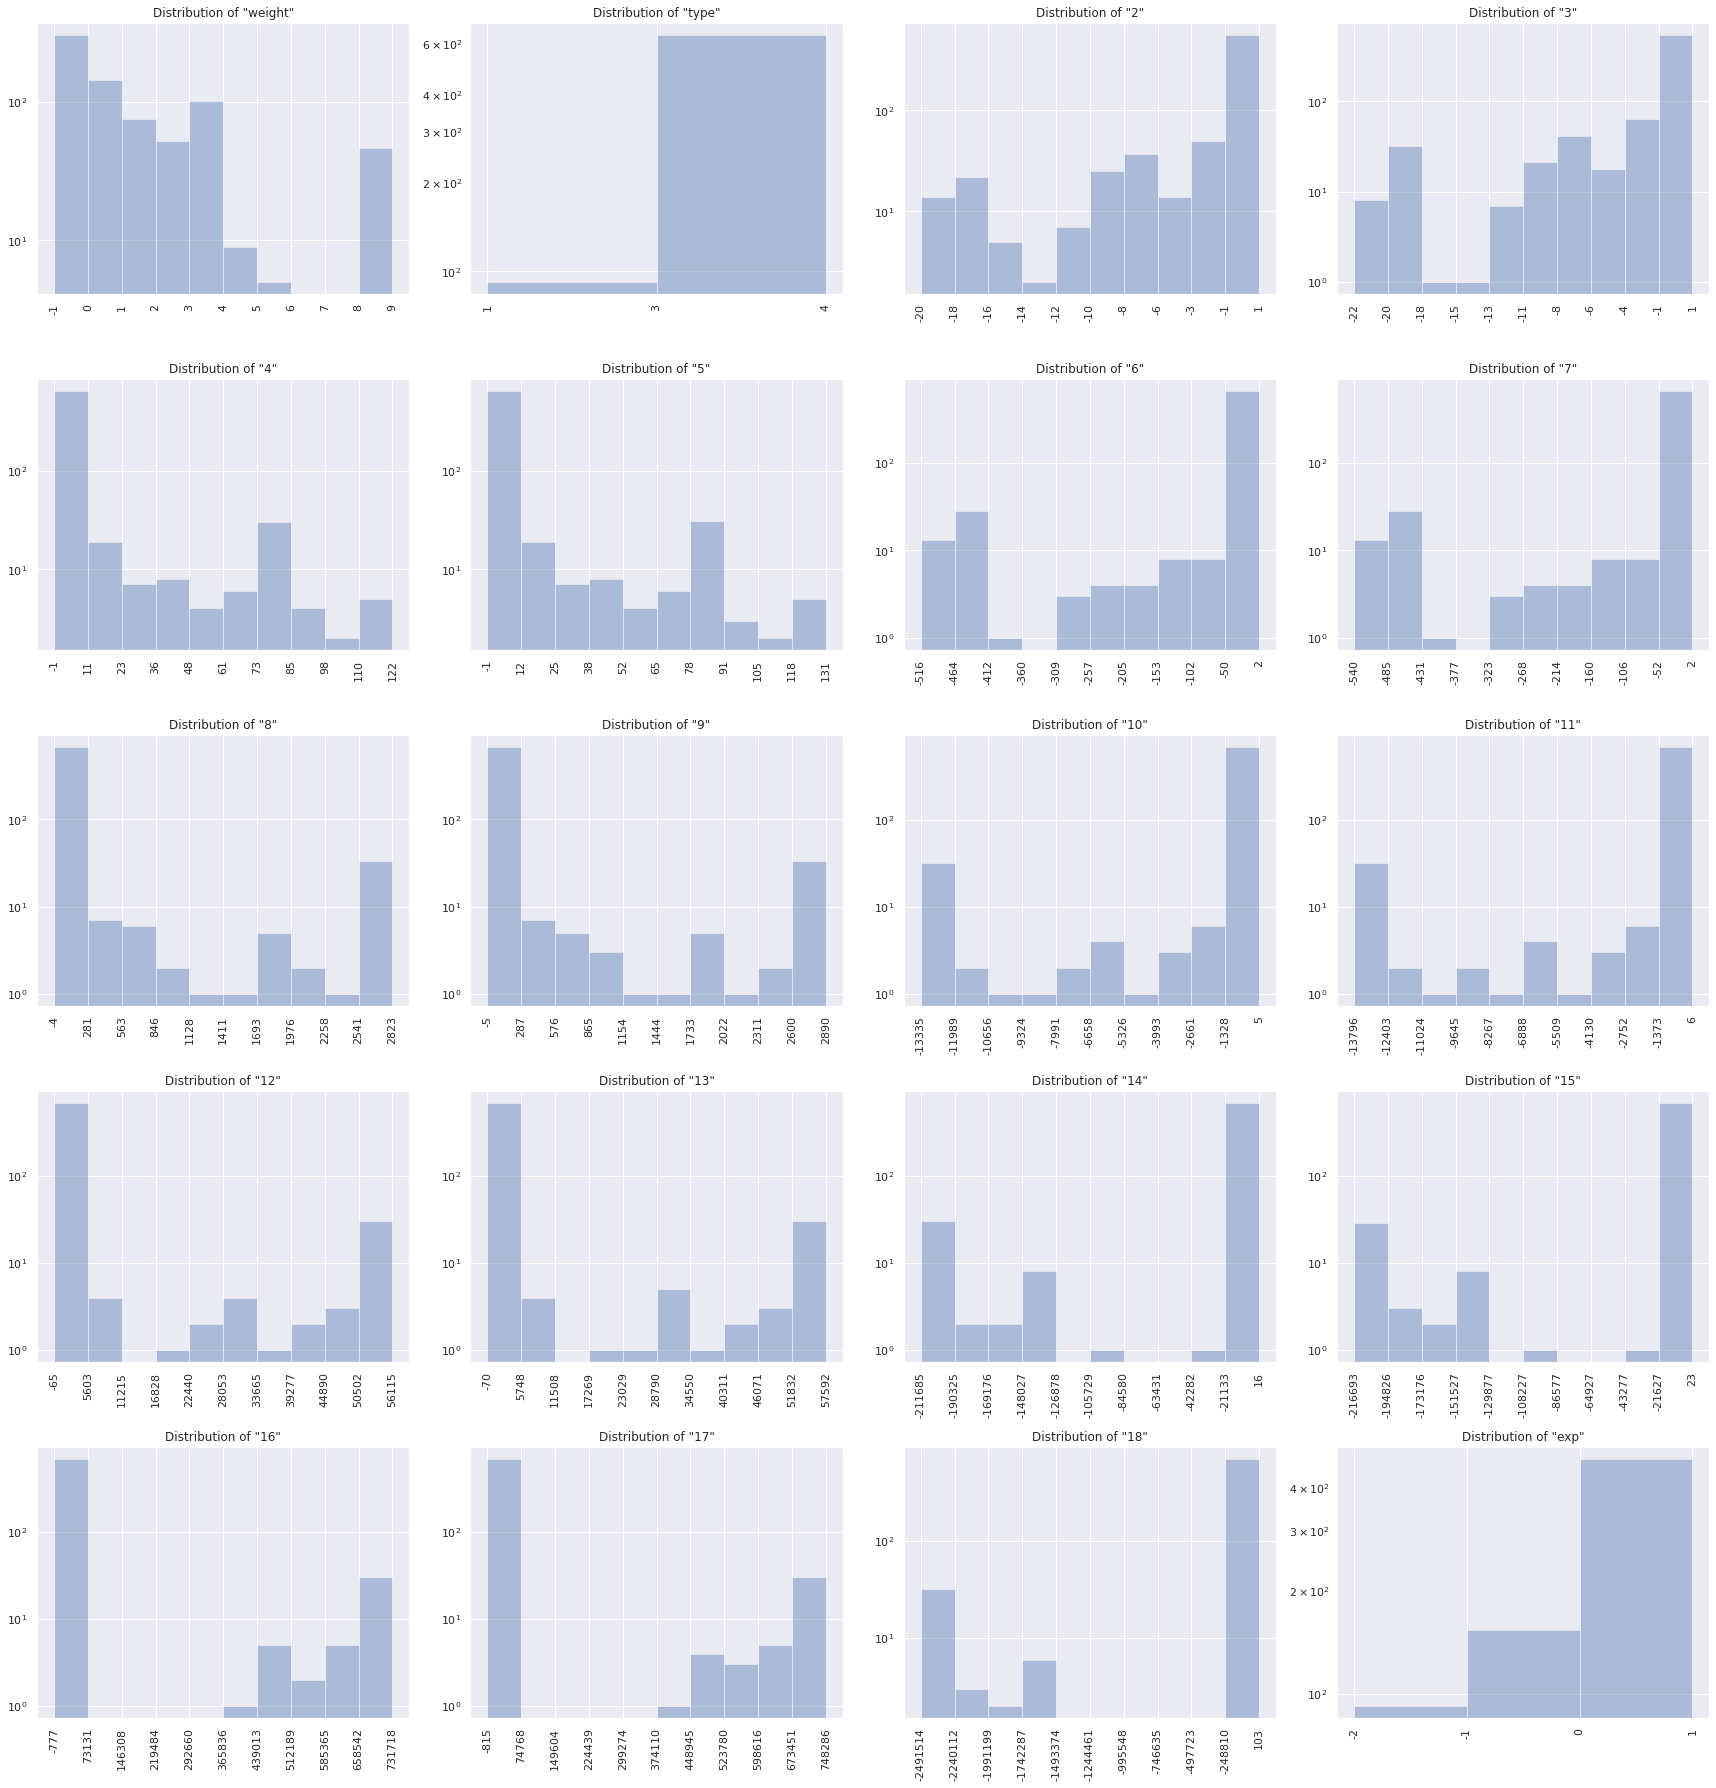

In [20]:
# define a version of the dataframe with only useful column for the plot
df_feature_plot = df.drop(columns = ['init', 'system'])

# define a function to draw one single plot given a feature column and the no. of bins
def digitize_plot(feature, n_bins, ax):
    '''
    Digitize the given feature into a certain amount of bins.
    
    Required arguments:
        feature: the feature to digitize,
        n_bins:  the no. of bins,
        ax:      the ax of the subplot.
    '''
    # check how many unique values are in the column
    n_unique = pd.unique(feature).shape[0]
    if n_unique < n_bins:
        n_bins = n_unique #--------------------------------------- n_bins should not be greater than the no. of unique values
        
    # labels and bins
    labels, bins = pd.cut(feature, #------------------------------ the column to digitize
                          bins    = n_bins, #--------------------- the no. of bins to create
                          labels  = range(n_bins), #-------------- call the labels sequentially
                          retbins = True #------------------------ return also the bins
                         )
    
    # plot the histogram
    sns.distplot(labels, bins = range(n_bins + 1), kde = False, axlabel = False, ax = ax)
    ax.set_title('Distribution of "{}"'.format(feature.name))
    ax.set_xticks(range(n_bins + 1))
    ax.set_xticklabels(np.floor(bins).astype(int), rotation = 90)
    ax.set_yscale('log')
    
# now draw a grid of histograms
ncols = 4
nrows = 5

# choose the number of bins
n_bins = 10

# take the names of the feature sand distribute them in the grid
features = np.array(df_feature_plot.columns).reshape(nrows, ncols)

# create the plot
distr_feature_fig, distr_feature_plot = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

for i in range(nrows):
    for j in range(ncols):
        digitize_plot(df_feature_plot[features[i,j]], n_bins, distr_feature_plot[i,j])

distr_feature_fig.tight_layout()
distr_feature_fig.savefig(path.join(IMG_PATH, 'distr_feature.pdf'), dpi = 300, format = 'pdf')
distr_feature_fig.savefig(path.join(IMG_PATH, 'distr_feature.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(distr_feature_fig)

We finally take a look at the distribution in size of the systems and the numeric partition of the labels in the dataset:

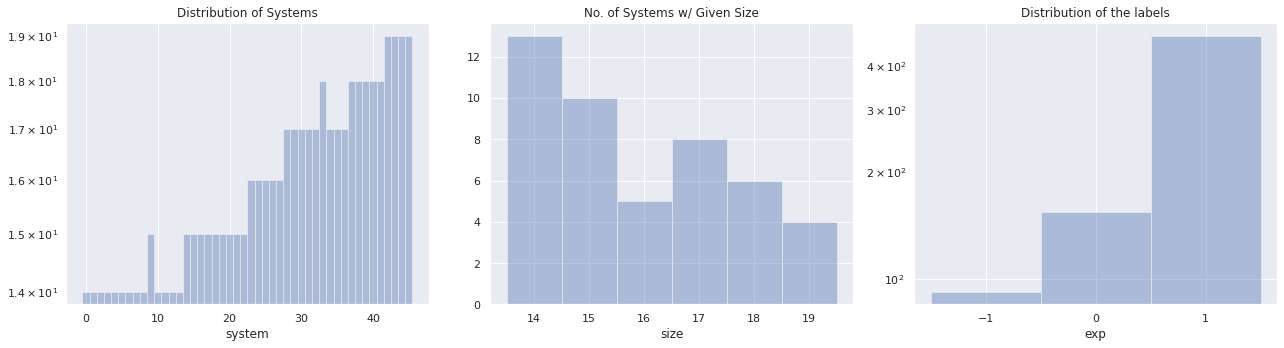

In [21]:
nrows = 1
ncols = 3
system_distr_fig, system_distr_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

system_data = df['system']
system_distr_plot[0].set(yscale = 'log', title = 'Distribution of Systems')
sns.distplot(system_data,
             bins     = range(system_data.min(), system_data.max() + 2),
             hist_kws = {'align': 'left'},
             kde      = False,
             axlabel  = 'system',
             ax       = system_distr_plot[0]
            )

size_data = df.groupby(by='system').count().max(axis = 1)
system_distr_plot[1].set(title = 'No. of Systems w/ Given Size')
sns.distplot(size_data,
             bins     = range(size_data.min(), size_data.max() + 2),
             hist_kws = {'align': 'left'},
             kde      = False,
             axlabel  = 'size',
             ax       = system_distr_plot[1]
            )

labels_data = df['exp']
system_distr_plot[2].set(yscale = 'log', title = 'Distribution of the labels', xticks = range(labels_data.min(), labels_data.max() + 1))
sns.distplot(labels_data,
             bins     = range(labels_data.min(), labels_data.max() + 2),
             hist_kws = {'align': 'left'},
             kde      = False,
             axlabel  = 'exp',
             ax       = system_distr_plot[2]
            )

system_distr_fig.tight_layout()
system_distr_fig.savefig(path.join(IMG_PATH, 'system_distr.pdf'), dpi = 300, format = 'pdf')
system_distr_fig.savefig(path.join(IMG_PATH, 'system_distr.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(system_distr_fig)

From the distribution therefore it seems that:

- in each system there is always a duplicate row, exception made for two systems which maintain the original number of elements (see 'Distribution of Systems'),
- the labels to predict are not balanced but we should not worry because we are trying to do a regression task,
- in the distribution of features there are a lot of outliers even though the majority of the features lie in a more restricted interval.

## Clustering Analysis

We now consider a quick clustering analysis using `K-Means` clustering to look for a pattern inside the data. The main idea would be to try and categorize the features into clusters with the same label.

In [22]:
n_clusters = pd.unique(df['exp']).shape[0] #-------- take the no. of clusters to be equal to the no. of labels

In order to do so we first select the features:

In [23]:
# remove the 0-th system as it won't improve anything (it's "too perfect"), take everything but "system", "init" and the label
X = df.loc[df['system'] != 0].drop(columns = ['system', 'init', 'exp'])

The we call the methods of the class `cluster.KMeans` in _Scikit_. We first rescale the inputs and standardise them:

In [24]:
from sklearn.pipeline      import Pipeline
from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.cluster       import KMeans

column_steps_1 = [('standard_scale_observables', StandardScaler(), slice(0, 1)), #---- standardize the first two columns (observable-related)
                  ('robust_scale_levels', RobustScaler(), slice(2, -1)) #------------- robust scale the level truncations
                 ]

#column_steps_2 = [('rescale_levels', MinMaxScaler(), slice(2,-1))] #------------------ rescale the level truncations

pipeline_steps = [('transform_1', ColumnTransformer(column_steps_1,
                                                    remainder = 'passthrough', #------- do not drop untouched columns
                                                    n_jobs    = THREADS
                                                   )
                  ), #----------------------------------------------------------------- transform separate columns (first step)
                  #('transform_2', ColumnTransformer(column_steps_2,
                  #                                  remainder = 'passthrough', #------- do not drop untouched columns
                  #                                  n_jobs    = THREADS
                  #                                 )
                  #), #----------------------------------------------------------------- transform separate columns (second step)
                  ('cluster', KMeans(n_clusters = n_clusters)) #----------------------- use clustering
                 ]

pipeline_trans = Pipeline(pipeline_steps) #-------------------------------------------- build the pipeline

log.info('Fitting KMeans clustering and robust scaling.')
clusters = pipeline_trans.fit_predict(X) #--------------------------------------------- fit the pipeline and get the clusters (calls fit_transform except for last step)

We then include clustering labels and the `exp` column in a different dataframe for plotting:

In [25]:
data     = pipeline_trans.named_steps['transform_1'].transform(X) #---------------------------- transform the X
clusters = clusters.reshape(-1, 1) #----------------------------------------------------------- get clustering labels
label    = df.loc[df['system'] != 0]['exp'].values.reshape(-1, 1) #---------------------------- extract the extrapolated predictions

column_list = df.loc[df['system'] != 0].drop(columns = ['system', 'init', 'exp']).columns #---- create a list of column names to be chosen from
plot_data = pd.DataFrame(data, columns = column_list) #---------------------------------------- create a dataframe with training data
plot_data['clusters'] = clusters #------------------------------------------------------------- save the labels of the clusters
plot_data['exp']    = label #------------------------------------------------------------------ include the label

Finally we plot the distribution of the clustering labels and the `exp` predictions using different colours for the labels and different style and size for the predictions.

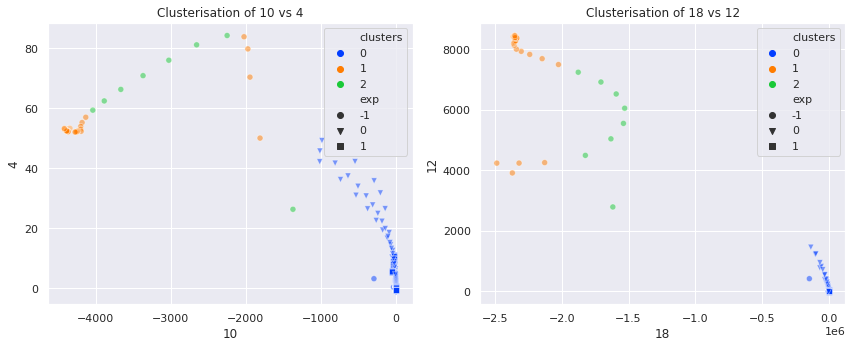

In [26]:
nrows = 1
ncols = 2
cluster_labels_fig, cluster_labels_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

sns.scatterplot(data    = plot_data,
                x       = '10',
                y       = '4',
                hue     = 'clusters',
                style   = 'exp',
                legend  = 'full',
                alpha   = 0.5,
                palette = sns.color_palette('bright', n_clusters),
                markers = ['o', 'v', 's'],
                ax      = cluster_labels_plot[0]
               )
cluster_labels_plot[0].set(title = 'Clusterisation of {} vs {}'.format('10', '4'))

sns.scatterplot(data    = plot_data,
                x       = '18',
                y       = '12',
                hue     = 'clusters',
                style   = 'exp',
                legend  = 'full',
                alpha   = 0.5,
                palette = sns.color_palette('bright', n_clusters),
                markers = ['o', 'v', 's'],
                ax      = cluster_labels_plot[1]
               )
cluster_labels_plot[1].set(title = 'Clusterisation of {} vs {}'.format('18', '12'))

cluster_labels_fig.tight_layout()
cluster_labels_fig.savefig(path.join(IMG_PATH, 'cluster_labels.pdf'), dpi = 300, format = 'pdf')
cluster_labels_fig.savefig(path.join(IMG_PATH, 'cluster_labels.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(cluster_labels_fig)

A match between clustering labels and predictions should be seen as a match between colours and marker style and size (at least approximate): this not the case however.

## Saving the Dataset

We can now save the dataset for further use.

In [27]:
df = df.loc[df['system'] != 0] #------------------------- drop the first system
df = df.reset_index(drop = True) #----------------------- reset the index

fp = path.join(DAT_PATH, 'sft-data_analysis.csv') #------ choose the filepath
df.to_csv(fp, index = False) #--------------------------- save the dataset

log.debug('Dataset saved to CSV file.')

# Analysis

we can now move to perform the analysis by first dividing the dataset into test and validation (development) sets: we separate the samples choosing the test in such a way to have a good amount of entries to retain generalisation ability, while the development set is chosen according to the trade off between the error of a simple linear regression and the size of the set.

Notice that in order to keep track of the physical content of the samples we will not directly separate the entries of the dataset: we will first separate the number of systems into train/dev/test sets and then assign the corresponding samples. Training will then be performed on the samples **without** any reference to `system` and `init`.

## Test Set Selection

We first reload the dataset and choose the composition of the test set in terms of `system`. We will choose 25% of the systems to be part of the test set.

In [28]:
from sklearn.model_selection import train_test_split

# reload the dataset
fp = path.join(DAT_PATH, 'sft-data_analysis.csv')
df = None
if path.isfile(fp):
    df = pd.read_csv(fp,
                     header    = 0 #--------------------------------------- use first row as column names
                    )
    
# check if dataset loaded correctly
if df is not None:
    log.debug('Dataset successfully reloaded.')
else:
    log.error('Cannot reload dataset!')
    
# select systems and choose the test partition
systems = pd.unique(df['system'])
systems_train, systems_test = train_test_split(systems,
                                               test_size    = 0.20,
                                               shuffle      = True, #------- remember to shuffle the dataset
                                               random_state = RAND
                                              ) #--------------------------- select test systems
if np.intersect1d(systems_train, systems_test).shape[0] == 0: #------------- sanity check
    log.debug('Test set for system has been selected.')
else:
    print('Test set is overlapping with training set!')
    log.error('Test set is overlapping with training set!')

We then shuffle and separate the samples inside the sets:

In [29]:
df_shuf       = df.sample(frac = 1, random_state = RAND) #------------ shuffle the dataset
df_train_full = df_shuf.loc[df['system'].isin(systems_train)] #------- select train (this is train + validation, not just train)
df_test       = df_shuf.loc[df['system'].isin(systems_test)] #-------- select test

if df_train_full.shape[0] + df_test.shape[0] != df.shape[0]: #-------- sanity check
    log.error('Missing data!')
    
print('Size of training + dev sets: {:.1f}% ({:d} samples)'.format(100 * df_train_full.shape[0] / df.shape[0], df_train_full.shape[0]))
print('Size of test set:            {:.1f}% ({:d} samples)'.format(100 * df_test.shape[0] / df.shape[0], df_test.shape[0]))
log.debug('Size of training + dev sets: {:.1f}% ({:d} samples)'.format(100 * df_train_full.shape[0] / df.shape[0], df_train_full.shape[0]))
log.debug('Size of test set:            {:.1f}% ({:d} samples)'.format(100 * df_test.shape[0] / df.shape[0], df_test.shape[0]))

Size of training + dev sets: 80.9% (581 samples)
Size of test set:            19.1% (137 samples)


## Validation Strategy

Given the nature of the problem and the fact that dev and test sets should come from the same distribution we would like to keep the separation of the systems also in the validation set. The number of samples is however very restricted: we choose to keep only one development set, separated from the effective training set.

We therefore study the optimal truncation of the training set by fitting a linear regression over a set of variable size:

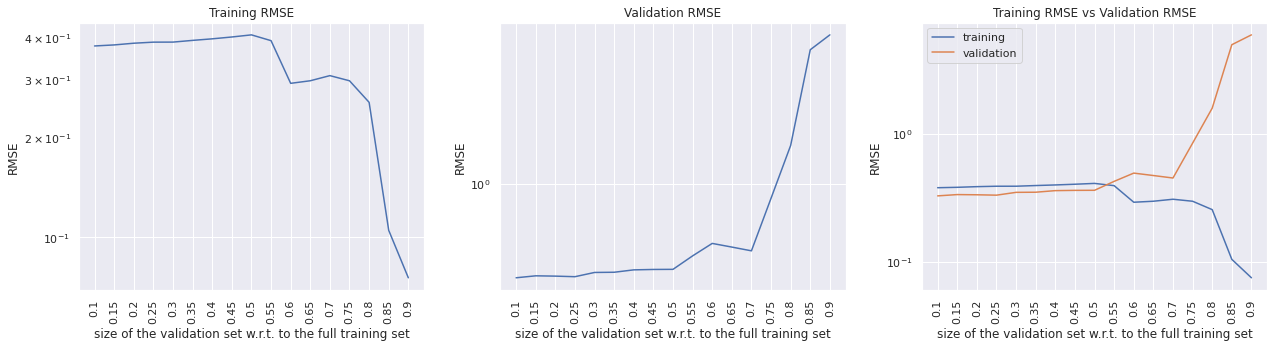

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_squared_error

# choose a range of sizes to explore
dev_sizes = np.linspace(0.10, 0.90, 17)

# prepare lists containing training and development errors
training_errors = np.zeros(dev_sizes.shape)
dev_errors      = np.zeros(dev_sizes.shape)

# loop over dev sizes
for n in range(dev_sizes.shape[0]):
    # divide systems into training and validation
    log.info('Starting with {:.1f}% dev set size.'.format(100 * dev_sizes[n]))
    systems_tmp_train, systems_tmp_dev = train_test_split(systems_train,
                                                          test_size = dev_sizes[n],
                                                          shuffle   = False
                                                         ) #--------------------------- select validation systems
    if np.intersect1d(systems_tmp_train, systems_tmp_dev).shape[0] == 0: #------------- sanity check
        log.debug('Dev set for system has been selected.')
    else:
        print('Dev set is overlapping with training set!')
        log.error('Dev set is overlapping with training set!')

    # insert samples into training and validation
    df_tmp_train = df_train_full.loc[df['system'].isin(systems_tmp_train)] #----------- select train
    df_tmp_dev   = df_train_full.loc[df['system'].isin(systems_tmp_dev)] #------------- select validation

    if df_tmp_train.shape[0] + df_tmp_dev.shape[0] != df_train_full.shape[0]: #-------- sanity check
        log.error('Missing data!')

    # output specifics
    log.debug('Size of training set:   {:.1f}% ({:d} samples) w.r.t. full training set ({:.1f}% w.r.t. to full set)'.format(100 * df_tmp_train.shape[0] / df_train_full.shape[0], df_tmp_train.shape[0], 100 * df_tmp_train.shape[0] / df.shape[0]))
    log.debug('Size of validation set: {:.1f}% ({:d} samples) w.r.t. full training set ({:.1f}% w.r.t. to full set)'.format(100 * df_tmp_dev.shape[0] / df_train_full.shape[0], df_tmp_dev.shape[0], 100 * df_tmp_dev.shape[0] / df.shape[0]))

    # standardize the input and fit the linear regression
    std_scl = StandardScaler()
    lin_reg = LinearRegression(n_jobs = THREADS)

    x_train = df_tmp_train.iloc[:, 2:-1] #------------------------------------ select training features: remove `system`, `init` and label column
    x_dev   = df_tmp_dev.iloc[:, 2:-1] #-------------------------------------- select development features: remove `system`, `init` and label column

    x_train = std_scl.fit_transform(x_train) #-------------------------------- standardize training features (fit and transform)
    x_dev   = std_scl.transform(x_dev) #-------------------------------------- standardize development features (transform only)

    y_train = df_tmp_train['exp'].values.reshape(-1, 1) #--------------------- training labels
    y_dev   = df_tmp_dev['exp'].values.reshape(-1, 1) #----------------------- development labels

    lin_reg.fit(x_train, y_train) #------------------------------------------- fit and predict
    y_train_pred = lin_reg.predict(x_train)
    y_dev_pred   = lin_reg.predict(x_dev)

    training_errors[n] = mean_squared_error(y_train,
                                            y_train_pred,
                                            squared = False #----------------- keep squared = False to get RMSE (instead of MSE)
                                           ) #-------------------------------- save the error metric
    dev_errors[n]      = mean_squared_error(y_dev,
                                            y_dev_pred,
                                            squared = False #----------------- keep squared = False to get RMSE (instead of MSE)
                                           ) #-------------------------------- save the error metric

# plot the results
data = pd.DataFrame({'size':       dev_sizes,
                     'train_rmse': training_errors,
                     'dev_rmse':   dev_errors
                    }
                   )

nrows = 1
ncols = 3
dev_set_choice_fig, dev_set_choice_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

sns.lineplot(data    = data,
             x       = 'size',
             y       = 'train_rmse',
             markers = True,
             ax      = dev_set_choice_plot[0]
            )
dev_set_choice_plot[0].set(title = 'Training RMSE', xlabel = 'size of the validation set w.r.t. to the full training set', ylabel = 'RMSE', xticks = data['size'], yscale = 'log')
dev_set_choice_plot[0].set_xticklabels(np.round(data['size'], 2), rotation = 90, ha = 'center')

sns.lineplot(data    = data,
             x       = 'size',
             y       = 'dev_rmse',
             markers = True,
             ax      = dev_set_choice_plot[1]
            )
dev_set_choice_plot[1].set(title = 'Validation RMSE', xlabel = 'size of the validation set w.r.t. to the full training set', ylabel = 'RMSE', xticks = data['size'], yscale = 'log')
dev_set_choice_plot[1].set_xticklabels(np.round(data['size'], 2), rotation = 90, ha = 'center')

sns.lineplot(data    = data,
             x       = 'size',
             y       = 'train_rmse',
             markers = True,
             label   = 'training',
             ax      = dev_set_choice_plot[2]
            )
sns.lineplot(data    = data,
             x       = 'size',
             y       = 'dev_rmse',
             markers = True,
             label   = 'validation',
             ax      = dev_set_choice_plot[2]
            )
dev_set_choice_plot[2].set(title = 'Training RMSE vs Validation RMSE', xlabel = 'size of the validation set w.r.t. to the full training set', ylabel = 'RMSE', xticks = data['size'], yscale = 'log')
dev_set_choice_plot[2].set_xticklabels(np.round(data['size'], 2), rotation = 90, ha = 'center')

dev_set_choice_fig.tight_layout()
dev_set_choice_fig.savefig(path.join(IMG_PATH, 'dev_set_choice.pdf'), dpi = 300, format = 'pdf')
dev_set_choice_fig.savefig(path.join(IMG_PATH, 'dev_set_choice.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(dev_set_choice_fig)

The results seem to show that:

- below a size of 50% of the full training set errors have a standard behaviour and are approximately constant,
- between 50% and 70% of the full training set a small variation in the size of the validation set leads to huge differences,
- above 70% the training set becomes so small that even a linear regression easily overfits it.

Given the results, the best option seems to avoid a split where the size of the validation set exceeds 50% of the training set. A good split may be therefore at around 40% of the training set:

In [31]:
best_dev_size     = 0.40
log.info('Chosen development size: {:.1f}% of the training set.'.format(best_dev_size))

# divide into training and development set
systems_train, systems_dev = train_test_split(systems_train,
                                              test_size    = best_dev_size,
                                              shuffle      = True,
                                              random_state = RAND
                                             ) #---------------------------------------------- select validation systems
if np.intersect1d(systems_train, systems_dev).shape[0] == 0: #-------------------------------- sanity check
    log.debug('Dev set for system has been selected.')
else:
    print('Dev set is overlapping with training set!')
    log.error('Dev set is overlapping with training set!')

# insert samples into training and validation
df_train      = df_train_full.loc[df['system'].isin(systems_train)] #------------------------ select train
df_dev        = df_train_full.loc[df['system'].isin(systems_dev)] #-------------------------- select validation

if df_train.shape[0] + df_dev.shape[0] != df_train.shape[0]: #------------------------------- sanity check
    log.error('Missing data!')

# output specifics
print('Size of training set:   {:.1f}% ({:d} samples) w.r.t. full training set ({:.1f}% w.r.t. to full set)'.format(100 * df_train.shape[0] / df_train_full.shape[0], df_train.shape[0], 100 * df_train.shape[0] / df.shape[0]))
print('Size of validation set: {:.1f}% ({:d} samples) w.r.t. full training set ({:.1f}% w.r.t. to full set)'.format(100 * df_dev.shape[0] / df_train_full.shape[0], df_dev.shape[0], 100 * df_dev.shape[0] / df.shape[0]))
log.debug('Size of training set:   {:.1f}% ({:d} samples) w.r.t. full training set ({:.1f}% w.r.t. to full set)'.format(100 * df_train.shape[0] / df_train_full.shape[0], df_train.shape[0], 100 * df_train.shape[0] / df.shape[0]))
log.debug('Size of validation set: {:.1f}% ({:d} samples) w.r.t. full training set ({:.1f}% w.r.t. to full set)'.format(100 * df_dev.shape[0] / df_train_full.shape[0], df_dev.shape[0], 100 * df_dev.shape[0] / df.shape[0]))

Size of training set:   58.2% (338 samples) w.r.t. full training set (47.1% w.r.t. to full set)
Size of validation set: 41.8% (243 samples) w.r.t. full training set (33.8% w.r.t. to full set)


We finally save the data in a readable format for later comparison:

In [32]:
fp_train = path.join(DAT_PATH, 'sft-data_train-set.csv')
df_train.sort_index(ignore_index = True).to_csv(fp_train, index = False)
log.debug('Train dataset saved to CSV file.')

fp_dev = path.join(DAT_PATH, 'sft-data_dev-set.csv')
df_dev.sort_index(ignore_index = True).to_csv(fp_dev, index = False)
log.debug('Development dataset saved to CSV file.')

fp_test = path.join(DAT_PATH, 'sft-data_test-set.csv')
df_test.sort_index(ignore_index = True).to_csv(fp_test, index = False)
log.debug('Test dataset saved to CSV file.')

## Machine Learning Analysis

We can now move to the machine learning analysis given the division into training, validation and test sets. We will fit several algorithms using `weight`, `type` and the truncation levels as input features (i.e. we do not use `system` which was artificially created and `init` which should not enter computation) and predict the label `exp`.

In [34]:
import re

from sklearn.linear_model    import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm             import LinearSVR, SVR
from lightgbm                import LGBMRegressor
from tensorflow              import keras
from sklearn.model_selection import ParameterGrid
from skopt                   import gp_minimize
from skopt.utils             import use_named_args
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from scipy                   import stats

def pretty_print(dictionary):
    '''
    Pretty print a dictionary.
    
    Required argument:
        dictionary: the dictionary.
    '''
    length = max([len(k) for k in dictionary.keys()])
    
    for key, value in dictionary.items():
        key   = key.ljust(length).replace('_', ' ').upper()
        key   = re.sub(r'(TRAIN|DEV|TEST) *$', lambda match: match.group(1).lower() + ' SET', key)
        value = value.lower() if isinstance(value, str) else value
        print('{} = {}'.format(key, value))
    print('\n')

def confidence_interval(y_true, y_pred, confidence = 0.95):
    '''
    Compute the confidence interval of the variance.
    
    Required arguments:
        y_true: true values,
        y_pred: predictions.
        
    Returns:
        the array of lower and upper bounds of the confidence interval.
    '''
    
    # compute the deviation of the data and the squared errors
    deviation = y_pred - y_true #-------------------------------------- > 0 if overestimating, < 0 if underestimating
    sq_errors = deviation ** 2 #--------------------------------------- squared errors

    conf_interval = stats.t.interval(confidence,
                                     sq_errors.shape[0] - 1,
                                     loc   = sq_errors.mean(),
                                     scale = stats.sem(sq_errors)
                                    ) #-------------------------------- compute the confidence interval
    
    return conf_interval

class Analysis:
    '''
    Build several algorithms and fit the data onto them.
    
    Public methods:
        linear_regression: linear regression algorithm,
        elastic_net:       elastic net regression algorithm (l1 and l2 regularised linear regression),
        lasso:             lasso regression algorithm (l1 regularised linear regression),
        ridge:             ridge regression algorithm (l2 regularised linear regression),
        linear_svr:        linear SVR algorithm,
        svr_rbf:           SVR algorithm with Gaussian (rbf) kernel,
        random_forest:     random forest of decision trees,
        gradient_boost:    boosted decision trees,
        ann:               artificial fully connected neural network.
        
    Private methods:
        __ann_model:       build the ANN model.
        
    Getters:
        get_train_data:    get training data (x_train, y_train),
        get_dev_data:      get dev data (x_dev, y_dev),
        get_test_data:     get test data (x_test, y_test),
        get_random_state:  get random state,
        get_n_jobs:        get no. of threads.
    
    Setters:
        set_train_data:    set training data,
        set_dev_data:      set dev data,
        set_test_data:     set test data,
        set_random_state:  set random state,
        set_n_jobs:        set no. of threads.
    '''
    
    def __init__(self,
                 train_data,
                 dev_data,
                 test_data,
                 random_state = None,
                 n_jobs = 1):
        '''
        Class constructor.
        
        Required arguments:
            train_data: tuple containing training data (x_train, y_train)
            dev_data:   tuple containing development data (x_dev, y_dev)
            test_data:  tuple containing test data (x_test, y_test)
            
        Optional arguments:
            random_state: the random seed,
            n_jobs:       the number of concurrent threads.
        '''
        # initialize the variables
        self.__x_train, self.__y_train = train_data
        self.__x_dev,   self.__y_dev   = dev_data
        self.__x_test,  self.__y_test  = test_data
        self.__random_state = random_state
        self.__n_jobs       = n_jobs
    
    # define the getters
    def get_train_data(self):
        '''
        Getter method for the training data.
        
        Returns:
            the training data
        '''
        return (self.__x_train, self.__y_train)
    
    def get_dev_data(self):
        '''
        Get method for the development data.
        
        Returns:
            the development data
        '''
        return (self.__x_dev, self.__y_dev)
    
    def get_test_data(self):
        '''
        Get method for the test data.
        
        Returns:
            the test data
        '''
        return (self.__x_test, self.__y_test)
    
    def get_random_state(self):
        '''
        Get method for the random state.
        
        Returns:
            the random state
        '''
        return self.__random_state
    
    def get_n_jobs(self):
        '''
        Get method for the no. of concurrent threads.
        
        Returns:
            the no. of concurrent threads
        '''
        return self.__n_jobs
    
    # define the setters
    def set_train_data(self, train_data):
        '''
        Set method for the training data.
        
        Required arguments:
            train_data: the training data.
        '''
        self.__x_train, self.__y_train = train_data
    
    def set_dev_data(self, dev_data):
        '''
        Set method for the development data.
        
        Required arguments:
            dev_data: the development data.
        '''
        self.__x_dev, self.__y_dev = dev_data
    
    def set_test_data(self, test_data):
        '''
        Set method for the test data.
        
        Required arguments:
            test_data: the test data.
        '''
        self.__x_test, self.__y_test = test_data
    
    def set_random_state(self, random_state):
        '''
        Set method for the random state.
        
        Required arguments:
            random_state: the random seed.
        '''
        self.__random_state = random_state
    
    def set_n_jobs(self, n_jobs):
        '''
        Set method for the no. of concurrent threads.
        
        Required arguments:
            n_jons: the no. of concurrent threads.
        '''
        self.__n_jobs = n_jobs
        
    # build a neural network model
    def __ann_model(self,
                    n_layers            = 1,
                    n_units             = 10,
                    learning_rate       = 0.1,
                    epochs              = 10,
                    activation          = 'relu',
                    slope               = 0.3,
                    dropout             = True,
                    dropout_rate        = 0.2,
                    batch_normalization = True,
                    momentum            = 0.99,
                    l1_reg              = 0.0,
                    l2_reg              = 0.0
                   ):
        '''
        Create and return a compiled Tensorflow model.

        Required parameters:

        Optional parameters:
            n_layers:            the number of fully connected layers to insert,
            n_units:             the number of units in each layer,
            learning_rate:       the learning rate of gradient descent,
            epochs:              the number of epochs for training,
            activation:          the name of the activation function ('relu' for ReLU or else for LeakyReLU)
            slope:               the slope of the LeakyReLU activation (ignored if ReLU),
            dropout:             whether to use dropout,
            dropout_rate:        the dropout rate (ignored if no dropout),
            batch_normalization: whether to use batch normalization,
            momentum:            the momentum of batch normalization,
            l1_reg:              amount of l1 regularisation,
            l2_reg:              amount of l2 regularisation.

        Returns:
            the fitted model and its history.
        '''

        # instantiate the model
        keras.backend.clear_session()
        model = keras.Sequential(name = 'sft_trunc') #--------------------------------------- create the model
        model.add(keras.layers.InputLayer(input_shape = self.__x_train.shape[1:], name='input'))

        # add FC layers
        for n in range(n_layers):
            model.add(keras.layers.Dense(units                = n_units,
                                         kernel_initializer   = keras.initializers.glorot_uniform(seed = self.__random_state),
                                         bias_initializer     = tf.zeros_initializer(),
                                         activity_regularizer = keras.regularizers.l1_l2(l1 = l1_reg, l2 = l2_reg),
                                         name                 = 'dense_{:d}'.format(n)
                                        )
                     ) #--------------------------------------------------------------------- add FC layer
            if activation == 'relu':
                model.add(keras.layers.Activation('relu',
                                                  name = 'activation_{:d}'.format(n)
                                                 )
                         )
            else:
                model.add(keras.layers.LeakyReLU(alpha = slope,
                                                 name  = 'activation_{:d}'.format(n)
                                                )
                         ) #----------------------------------------------------------------- add activation layer
            if batch_normalization:
                model.add(keras.layers.BatchNormalization(momentum = momentum,
                                                          name     = 'batch_norm_{:d}'.format(n)
                                                         )
                         ) #----------------------------------------------------------------- add batch normalization layer
            if dropout:
                model.add(keras.layers.Dropout(rate = dropout_rate,
                                               seed = self.__random_state,
                                               name = 'dropout_{:d}'.format(n)
                                              )
                         ) #----------------------------------------------------------------- add dropout layer

        # add the output layer
        model.add(keras.layers.Dense(units              = 1,
                                     kernel_initializer = keras.initializers.glorot_uniform(seed = self.__random_state),
                                     bias_initializer   = tf.zeros_initializer(),
                                     name               = 'output'
                                    )
                 ) #------------------------------------------------------------------------- add output layer

        # compile the model
        model.compile(keras.optimizers.Adam(learning_rate = learning_rate),
                      loss       = keras.losses.MeanSquaredError(),
                      metrics    = [keras.metrics.MeanSquaredError(), keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError()]
                     )

        return model
    
    # define the algorithms
    def linear_regression(self, params, optimization = False):
        '''
        Linear regression model.
        
        Required arguments:
            params:       dict of hyperparameters.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (grid search).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # initialise parameters
            best_model           = None #--------------------------------------------------------- unknown for the moment
            best_hyperparameters = None #------------------------------------------------------------- unknown for the moment
            best_mae_train       = np.inf #------------------------------------------------------- highest possible value
            best_mae_dev         = np.inf #------------------------------------------------------- highest possible value
            best_mae_test        = np.inf #------------------------------------------------------- highest possible value
            best_mse_train       = np.inf #------------------------------------------------------- highest possible value
            best_mse_dev         = np.inf #------------------------------------------------------- highest possible value
            best_mse_test        = np.inf #------------------------------------------------------- highest possible value
            best_r2_train        = -np.inf #------------------------------------------------------ highest possible value
            best_r2_dev          = -np.inf #------------------------------------------------------ highest possible value
            best_r2_test         = -np.inf #------------------------------------------------------ highest possible value
            best_evr_train       = -np.inf #------------------------------------------------------ highest possible value
            best_evr_dev         = -np.inf #------------------------------------------------------ highest possible value
            best_evr_test        = -np.inf #------------------------------------------------------ highest possible value
            best_train_pred      = None #--------------------------------------------------------- unknown for the moment
            best_dev_pred        = None #--------------------------------------------------------- unknown for the moment
            best_test_pred       = None #--------------------------------------------------------- unknown for the moment
            best_cint_train      = None #--------------------------------------------------------- unknown for the moment
            best_cint_dev        = None #--------------------------------------------------------- unknown for the moment
            best_cint_test       = None #--------------------------------------------------------- unknown for the moment
            
            # generate a grid of choices and loop over it
            params_grid = list(ParameterGrid(params)) #------------------------------------------- create a grid of possible choices
            for i in range(len(params_grid)):
                log.debug('Exploring {}'.format(params_grid[i]))
                lin_reg = LinearRegression(n_jobs = self.__n_jobs,
                                           normalize = False,
                                           **params_grid[i]
                                          )
                lin_reg.fit(self.__x_train, self.__y_train.ravel()) #------------------------------ fit the estimator
                
                y_train_pred = lin_reg.predict(self.__x_train).reshape(-1,1) #--------------------- generate training predictions
                y_dev_pred   = lin_reg.predict(self.__x_dev).reshape(-1,1) #----------------------- generate development predictions
                y_test_pred  = lin_reg.predict(self.__x_test).reshape(-1,1) #---------------------- generate test predictions
                
                mae_train  = mean_absolute_error(self.__y_train, y_train_pred) #------------------- compute MAE for training data
                mae_dev    = mean_absolute_error(self.__y_dev, y_dev_pred) #----------------------- compute MAE for validation data
                mae_test   = mean_absolute_error(self.__y_test, y_test_pred) #--------------------- compute MAE for test data
                mse_train  = mean_squared_error(self.__y_train, y_train_pred) #-------------------- compute MSE for training data
                mse_dev    = mean_squared_error(self.__y_dev, y_dev_pred) #------------------------ compute MSE for validation data
                mse_test   = mean_squared_error(self.__y_test, y_test_pred) #---------------------- compute MSE for test data
                r2_train   = r2_score(self.__y_train, y_train_pred) #------------------------------ compute R2 for training data
                r2_dev     = r2_score(self.__y_dev, y_dev_pred) #---------------------------------- compute R2 for validation data
                r2_test    = r2_score(self.__y_test, y_test_pred) #-------------------------------- compute R2 for test data
                evr_train  = explained_variance_score(self.__y_train, y_train_pred) #-------------- compute EVR for training data
                evr_dev    = explained_variance_score(self.__y_dev, y_dev_pred) #------------------ compute EVR for validation data
                evr_test   = explained_variance_score(self.__y_test, y_test_pred) #---------------- compute EVR for test data
                cint_train = confidence_interval(self.__y_train, y_train_pred) #------------------- compute 95% confindence for training data
                cint_dev   = confidence_interval(self.__y_dev, y_dev_pred) #----------------------- compute 95% confindence for validation data
                cint_test  = confidence_interval(self.__y_test, y_test_pred) #--------------------- compute 95% confindence for test data
                
                if mse_dev < best_mse_dev: #------------------------------------------------------- update the best results (only dev set for comparison)
                    best_model           = lin_reg
                    best_hyperparameters = params_grid[i]
                    best_mae_train       = mae_train
                    best_mae_dev         = mae_dev
                    best_mae_test        = mae_test
                    best_mse_train       = mse_train
                    best_mse_dev         = mse_dev
                    best_mse_test        = mse_test
                    best_r2_train        = r2_train
                    best_r2_dev          = r2_dev
                    best_r2_test         = r2_test
                    best_evr_train       = evr_train
                    best_evr_dev         = evr_dev
                    best_evr_test        = evr_test
                    best_train_pred      = y_train_pred
                    best_dev_pred        = y_dev_pred
                    best_test_pred       = y_test_pred
                    best_cint_train      = cint_train
                    best_cint_dev        = cint_dev
                    best_cint_test       = cint_test
            
            # organise the predictions
            best_predictions = {'y_train_pred': best_train_pred,
                                'y_dev_pred':   best_dev_pred,
                                'y_test_pred':  best_test_pred
                               }
            
            # organise the metrics
            best_metrics = {'mae_train': best_mae_train,
                            'mae_dev':   best_mae_dev,
                            'mae_test':  best_mae_test,
                            'mse_train': best_mse_train,
                            'mse_dev':   best_mse_dev,
                            'mse_test':  best_mse_test,
                            'r2_train':  best_r2_train,
                            'r2_dev':    best_r2_dev,
                            'r2_test':   best_r2_test,
                            'evr_train': best_evr_train,
                            'evr_dev':   best_evr_dev,
                            'evr_test':  best_evr_test
                           }
            
            # organise the confidence intervals
            best_cint = {'train': best_cint_train,
                         'dev':   best_cint_dev,
                         'test':  best_cint_test
                        }
            
            return best_model, best_hyperparameters, best_predictions, best_metrics, best_cint
        else:
            # define the estimator and fit
            lin_reg = LinearRegression(n_jobs = self.__n_jobs, normalize = False, **params) #------- define the estimator
            lin_reg.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = lin_reg.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = lin_reg.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = lin_reg.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred), #------------------- compute 95% confindence for training data
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred), #----------------------- compute 95% confindence for validation data
                    'test':  confidence_interval(self.__y_test, y_test_pred) #---------------------- compute 95% confindence for test data
                   }
            
            return lin_reg, predictions, metrics, cint
        
    def elastic_net(self, params, optimization = False, n_calls = 10, max_iter = 1e3, tol = 1.0e-4):
        '''
        Elastic Net regression model.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            max_iter:     maximum number of iterations (elastic net),
            tol:          tolerance (elastic net).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            el_net = ElasticNet(random_state = self.__random_state,
                                normalize = False,
                                max_iter = max_iter,
                                tol = tol
                               )
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                el_net.set_params(**args)
                el_net.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = el_net.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            el_net_res = gp_minimize(objective,
                                     params,
                                     n_calls = n_calls,
                                     random_state = self.__random_state,
                                     n_jobs = self.__n_jobs
                                    )
            best_hyperparameters = dict(zip(hyp_names, el_net_res.x))
            
            # set best hyperparameters and fit the model
            el_net.set_params(**best_hyperparameters)
            el_net.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = el_net.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = el_net.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = el_net.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #---------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #----------- compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #--------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------ compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #---------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #-------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #---------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #-------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------ compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------ compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #---------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #--------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return el_net, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            el_net = ElasticNet(random_state = self.__random_state, **params) #-------------------- define the estimator
            el_net.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = el_net.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = el_net.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = el_net.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #---------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #----------- compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #--------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------ compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #---------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #-------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #---------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #-------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------ compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------ compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #---------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #--------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return el_net, predictions, metrics, cint
        
    def lasso(self, params, optimization = False, n_calls = 10, max_iter = 1e3, tol = 1.0e-4):
        '''
        Lasso regression model.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            max_iter:     maximum number of iterations (lasso),
            tol:          tolerance (lasso).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            lasso = Lasso(random_state = self.__random_state,
                          normalize = False,
                          positive = False,
                          max_iter = max_iter,
                          tol = tol
                         )
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                lasso.set_params(**args)
                lasso.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = lasso.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            lasso_res = gp_minimize(objective,
                                    params,
                                    n_calls = n_calls,
                                    random_state = self.__random_state,
                                    n_jobs = self.__n_jobs
                                   )
            best_hyperparameters = dict(zip(hyp_names, lasso_res.x))
            
            # set best hyperparameters and fit the model
            lasso.set_params(**best_hyperparameters)
            lasso.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = lasso.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = lasso.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = lasso.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #--------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #---------- compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #-------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #------------ compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #----------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #--------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #--------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #----------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #----- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #--------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #-------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return lasso, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            lasso = Lasso(random_state = self.__random_state,
                          normalize = False,
                          positive = False,
                          max_iter = max_iter,
                          tol = tol,
                          **params
                         )
            lasso.fit(self.__x_train, self.__y_train.ravel()) #--------------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = lasso.predict(self.__x_train).reshape(-1,1) #---------------------------- compute training predictions
            y_dev_pred   = lasso.predict(self.__x_dev).reshape(-1,1) #------------------------------ compute validation predictions
            y_test_pred  = lasso.predict(self.__x_test).reshape(-1,1) #----------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #--------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return lasso, predictions, metrics, cint
        
    def ridge(self, params, optimization = False, n_calls = 10, max_iter = 1e3, tol = 1.0e-4):
        '''
        Ridge regression model.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            max_iter:     maximum number of iterations (ridge),
            tol:          tolerance (ridge).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            ridge = Ridge(random_state = self.__random_state,
                          normalize = False,
                          max_iter = max_iter,
                          tol = tol
                         )
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                ridge.set_params(**args)
                ridge.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = ridge.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            ridge_res = gp_minimize(objective,
                                    params,
                                    n_calls = n_calls,
                                    random_state = self.__random_state,
                                    n_jobs = self.__n_jobs
                                   )
            best_hyperparameters = dict(zip(hyp_names, ridge_res.x))
            
            # set best hyperparameters and fit the model
            ridge.set_params(**best_hyperparameters)
            ridge.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = ridge.predict(self.__x_train).reshape(-1,1) #---------------------------- compute training predictions
            y_dev_pred   = ridge.predict(self.__x_dev).reshape(-1,1) #------------------------------ compute validation predictions
            y_test_pred  = ridge.predict(self.__x_test).reshape(-1,1) #----------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return ridge, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            ridge = Ridge(random_state = self.__random_state,
                          normalize = False,
                          max_iter = max_iter,
                          tol = tol,
                          **params
                         )
            ridge.fit(self.__x_train, self.__y_train.ravel()) #--------------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = ridge.predict(self.__x_train).reshape(-1,1) #---------------------------- compute training predictions
            y_dev_pred   = ridge.predict(self.__x_dev).reshape(-1,1) #------------------------------ compute validation predictions
            y_test_pred  = ridge.predict(self.__x_test).reshape(-1,1) #----------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return ridge, predictions, metrics, cint
        
    def linear_svr(self, params, optimization = False, n_calls = 10, max_iter = 1e3):
        '''
        Linear SVR regression model.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            max_iter:     maximum number of iterations (linear SVR).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            lin_svr = LinearSVR(random_state = self.__random_state, max_iter = max_iter)
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                lin_svr.set_params(**args)
                lin_svr.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = lin_svr.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            lin_svr_res = gp_minimize(objective,
                                      params,
                                      n_calls = n_calls,
                                      random_state = self.__random_state,
                                      n_jobs = self.__n_jobs
                                     )
            best_hyperparameters = dict(zip(hyp_names, lin_svr_res.x))
            
            # set best hyperparameters and fit the model
            lin_svr.set_params(**best_hyperparameters)
            lin_svr.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = lin_svr.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = lin_svr.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = lin_svr.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return lin_svr, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            lin_svr = LinearSVR(random_state = self.__random_state, max_iter = max_iter, **params)
            lin_svr.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = lin_svr.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = lin_svr.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = lin_svr.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return lin_svr, predictions, metrics, cint
        
    def svr_rbf(self, params, optimization = False, n_calls = 10, tol = 1.0e-4):
        '''
        SVR regression model using a Gaussian kernel (rbf).
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation,
            tol:          tolerance (SVR).
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            svr_rbf = SVR(kernel = 'rbf', tol = tol)
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                svr_rbf.set_params(**args)
                svr_rbf.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = svr_rbf.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            svr_rbf_res = gp_minimize(objective,
                                      params,
                                      n_calls = n_calls,
                                      random_state = self.__random_state,
                                      n_jobs = self.__n_jobs
                                     )
            best_hyperparameters = dict(zip(hyp_names, svr_rbf_res.x))
            
            # set best hyperparameters and fit the model
            svr_rbf.set_params(**best_hyperparameters)
            svr_rbf.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = svr_rbf.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = svr_rbf.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = svr_rbf.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return svr_rbf, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            svr_rbf = SVR(kernel = 'rbf', tol = tol, **params)
            svr_rbf.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = svr_rbf.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = svr_rbf.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = svr_rbf.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return svr_rbf, predictions, metrics, cint
        
    def random_forest(self, params, optimization = False, n_calls = 10):
        '''
        Random forest of decision trees.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation.
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            rnd_for = LGBMRegressor(boosting_type = 'rf', objective = 'regression', subsample_freq = 1, n_jobs = 1)
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                rnd_for.set_params(**args)                    
                rnd_for.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = rnd_for.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            rnd_for_res = gp_minimize(objective,
                                      params,
                                      n_calls = n_calls,
                                      random_state = self.__random_state,
                                      n_jobs = self.__n_jobs
                                     )
            best_hyperparameters = dict(zip(hyp_names, rnd_for_res.x))
            
            # set best hyperparameters and fit the model
            rnd_for.set_params(**best_hyperparameters)
            rnd_for.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = rnd_for.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = rnd_for.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = rnd_for.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return rnd_for, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            rnd_for = LGBMRegressor(boosting_type = 'rf',
                                    objective = 'regression',
                                    subsample_freq = 1,
                                    n_jobs = self.__n_jobs,
                                    **params
                                   )
            rnd_for.fit(self.__x_train, self.__y_train.ravel()) #----------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = rnd_for.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = rnd_for.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = rnd_for.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return rnd_for, predictions, metrics, cint
        
    def gradient_boosting(self, params, optimization = False, n_calls = 10):
        '''
        Boosted decision trees.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation.
            
        Returns:
            the fitted model, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # define the estimator
            grd_boost = LGBMRegressor(boosting_type = 'gbdt',
                                      objective = 'regression',
                                      subsample_freq = 1,
                                      n_jobs = 1
                                     )
            
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # fit the estimator to the train set
                grd_boost.set_params(**args)                    
                grd_boost.fit(self.__x_train, self.__y_train.ravel())
                
                # compute predictions on the dev set
                y_dev_pred = grd_boost.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            grd_boost_res = gp_minimize(objective,
                                        params,
                                        n_calls = n_calls,
                                        random_state = self.__random_state,
                                        n_jobs = self.__n_jobs
                                       )
            best_hyperparameters = dict(zip(hyp_names, grd_boost_res.x))
            
            # set best hyperparameters and fit the model
            grd_boost.set_params(**best_hyperparameters)
            grd_boost.fit(self.__x_train, self.__y_train.ravel())
            
            # compute the predictions
            y_train_pred = grd_boost.predict(self.__x_train).reshape(-1,1) #------------------------ compute training predictions
            y_dev_pred   = grd_boost.predict(self.__x_dev).reshape(-1,1) #-------------------------- compute validation predictions
            y_test_pred  = grd_boost.predict(self.__x_test).reshape(-1,1) #------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return grd_boost, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            grd_boost = LGBMRegressor(boosting_type = 'gbdt',
                                      objective = 'regression',
                                      subsample_freq = 1,
                                      n_jobs = self.__n_jobs,
                                      **params
                                     )
            grd_boost.fit(self.__x_train, self.__y_train.ravel()) #--------------------------------- fit the estimator
            
            # compute the predictions
            y_train_pred = grd_boost.predict(self.__x_train).reshape(-1,1) #------------------------ compute training predictions
            y_dev_pred   = grd_boost.predict(self.__x_dev).reshape(-1,1) #-------------------------- compute validation predictions
            y_test_pred  = grd_boost.predict(self.__x_test).reshape(-1,1) #------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #----------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return grd_boost, predictions, metrics, cint
        
    def ann_model(self, params, batch_size = 32, epochs = 10, verbose = 1, filename = 'ann_model.h5', optimization = False, n_calls = 10):
        '''
        Boosted decision trees.
        
        Required arguments:
            params:       dict of hyperparameters or list of skopt.Spaces.
        
        Optional arguments:
            batch_size:   the size of the mini-batch or batch gradient descent,
            epochs:       the training epochs,
            verbose:      enable verbosity,
            filename:     location of the saved model,
            optimization: if False then the estimators takes params as hyperparameters and outputs the predictions,
                          if True params are passed to the optimization procedure (Bayes search),
            n_calls:      the number of iterations of the Bayes optimisation.
            
        Returns:
            the fitted model, its history, the predictions, the metrics, the confidence intervals (if optimization is False),
            the best fitted model, its history, the best parameters, the predictions, the metrics, the confidence intervals (if optimization is True).
        '''
        if optimization:
            # get the list of names of the hyperparameters
            hyp_names = [s.name for s in params]
            
            # define the loss function
            @use_named_args(params)
            def objective(**args):
                # save iteration
                log.debug('Exploring {}'.format(args))
                
                # create the model
                ann_model = self.__ann_model(**args)
                
                # fit the estimator to the train set            
                ann_model_history = ann_model.fit(x               = self.__x_train,
                                                  y               = self.__y_train,
                                                  batch_size      = batch_size,
                                                  epochs          = epochs,
                                                  verbose         = 0,
                                                  validation_data = (self.__x_dev, self.__y_dev),
                                                  callbacks       = [keras.callbacks.ModelCheckpoint(filename,
                                                                                                     monitor        = 'val_loss',
                                                                                                     verbose        = 0,
                                                                                                     save_best_only = True
                                                                                                    )
                                                                    ]
                                                 )
            
                #restore best model
                ann_model = keras.models.load_model(filename)
                
                # compute predictions on the dev set
                y_dev_pred = ann_model.predict(self.__x_dev).reshape(-1,1)
                
                # compute the mean squared error
                return mean_squared_error(self.__y_dev, y_dev_pred)
            
            # compute the minimisation
            ann_model_res = gp_minimize(objective,
                                        params,
                                        n_calls = n_calls,
                                        random_state = self.__random_state,
                                        n_jobs = self.__n_jobs
                                       )
            best_hyperparameters = dict(zip(hyp_names, ann_model_res.x))
            
            # set best hyperparameters and fit the model
            ann_model = self.__ann_model(**best_hyperparameters)            
            ann_model_history = ann_model.fit(x               = self.__x_train,
                                              y               = self.__y_train,
                                              batch_size      = batch_size,
                                              epochs          = epochs,
                                              verbose         = 0,
                                              validation_data = (self.__x_dev, self.__y_dev),
                                              callbacks       = [keras.callbacks.ModelCheckpoint(filename,
                                                                                                 monitor        = 'val_loss',
                                                                                                 verbose        = 0,
                                                                                                 save_best_only = True
                                                                                                )
                                                                ]
                                             )
            
            #restore best model
            ann_model = keras.models.load_model(filename)
            
            # compute the predictions
            y_train_pred = ann_model.predict(self.__x_train).reshape(-1,1) #-------------------------- compute training predictions
            y_dev_pred   = ann_model.predict(self.__x_dev).reshape(-1,1) #---------------------------- compute validation predictions
            y_test_pred  = ann_model.predict(self.__x_test).reshape(-1,1) #--------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #--------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return ann_model, ann_model_history.history, best_hyperparameters, predictions, metrics, cint                
        else:
            # define the estimator and fit
            ann_model = self.__ann_model(**params)
            ann_model_history = ann_model.fit(x               = self.__x_train,
                                              y               = self.__y_train,
                                              batch_size      = batch_size,
                                              epochs          = epochs,
                                              verbose         = verbose,
                                              validation_data = (self.__x_dev, self.__y_dev),
                                              callbacks       = [keras.callbacks.ModelCheckpoint(filename,
                                                                                                 monitor        = 'val_loss',
                                                                                                 verbose        = verbose,
                                                                                                 save_best_only = True
                                                                                                )
                                                                ]
                                             )
            
            #restore best model
            ann_model = keras.models.load_model(filename)
            
            # compute the predictions
            y_train_pred = ann_model.predict(self.__x_train).reshape(-1,1) #------------------------ compute training predictions
            y_dev_pred   = ann_model.predict(self.__x_dev).reshape(-1,1) #-------------------------- compute validation predictions
            y_test_pred  = ann_model.predict(self.__x_test).reshape(-1,1) #------------------------- compute test predictions
            
            predictions = {'y_train_pred': y_train_pred,
                           'y_dev_pred':   y_dev_pred,
                           'y_test_pred':  y_test_pred
                          } #--------------------------------------------------------------------- collect predictions
            
            # compute the metrics
            metrics = {'mae_train': mean_absolute_error(self.__y_train, y_train_pred), #------------ compute MAE of training predictions
                       'mae_dev':   mean_absolute_error(self.__y_dev, y_dev_pred), #---------------- compute MAE of validation predictions
                       'mae_test':  mean_absolute_error(self.__y_test, y_test_pred), #-------------- compute MAE of test predictions
                       'mse_train': mean_squared_error(self.__y_train, y_train_pred), #------------- compute MSE of training predictions
                       'mse_dev':   mean_squared_error(self.__y_dev, y_dev_pred), #----------------- compute MSE of validation predictions
                       'mse_test':  mean_squared_error(self.__y_test, y_test_pred), #--------------- compute MSE of test predictions
                       'r2_train':  r2_score(self.__y_train, y_train_pred), #----------------------- compute R2 of training predictions
                       'r2_dev':    r2_score(self.__y_dev, y_dev_pred), #--------------------------- compute R2 of validation predictions
                       'r2_test':   r2_score(self.__y_test, y_test_pred), #------------------------- compute R2 of test predictions
                       'evr_train': explained_variance_score(self.__y_train, y_train_pred), #------- compute explained variance ratio of training predictions
                       'evr_dev':   explained_variance_score(self.__y_dev, y_dev_pred), #----------- compute explained variance ratio of validation predictions
                       'evr_test':  explained_variance_score(self.__y_test, y_test_pred) #---------- compute explained variance ratio of test predictions
                      }
            
            # compute the confidence intervals
            cint = {'train': confidence_interval(self.__y_train, y_train_pred),
                    'dev':   confidence_interval(self.__y_dev, y_dev_pred),
                    'test':  confidence_interval(self.__y_test, y_test_pred)
                   }
            
            return ann_model, ann_model_history.history, predictions, metrics, cint

We then prepare the input of the algorithms:

In [38]:
from sklearn.preprocessing import StandardScaler

train_slice = df_train.drop(columns = ['system', 'init', 'exp'])
dev_slice   = df_dev.drop(columns = ['system', 'init', 'exp'])
test_slice  = df_test.drop(columns = ['system', 'init', 'exp'])

scaling = StandardScaler()
x_train = train_slice.values #----------------------------------- select training features: remove `system`, `init` and label column
x_dev   = dev_slice.values #------------------------------------- select development features: remove `system`, `init` and label column
x_test  = test_slice.values #------------------------------------ select test features: remove `system`, `init` and label column

x_train = scaling.fit_transform(x_train) #----------------------- standardize training features (fit and transform)
x_dev   = scaling.transform(x_dev) #----------------------------- standardize development features (transform only)
x_test  = scaling.transform(x_test) #---------------------------- standardize test features (transform only)

y_train = df_train['exp'].values.reshape(-1, 1) #---------------- training labels
y_dev   = df_dev['exp'].values.reshape(-1, 1) #------------------ development labels
y_test  = df_test['exp'].values.reshape(-1, 1) #----------------- test labels

analysis = Analysis((x_train, y_train),
                    (x_dev, y_dev),
                    (x_test, y_test),
                    random_state = RAND,
                    n_jobs       = THREADS
                   ) #------------------------------------------- define the analysis framework

The distribution of the features can also be visualised in a categorical _stripplot_. It might be useful to compare the distributions of data inside the train/dev/test splits.

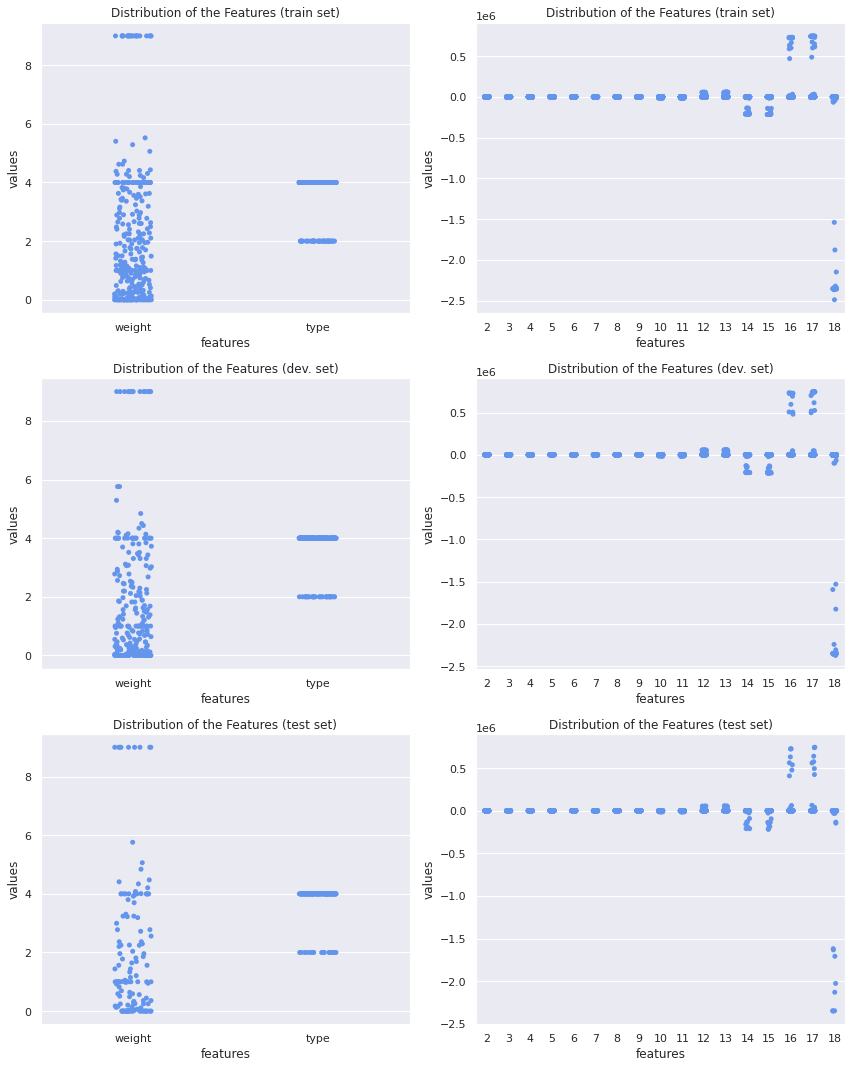

In [41]:
# create a unique dataframe with all values in one column and all column types associated as a second column
# e.g.:       | value | type
#          0  | 9.000 | weight
#          1  | 0.000 | weight
#          ...
#          333| 4.000 | type
#          334| 2.000 | type
#
cat_train_obs_types_pre_scl = pd.concat([pd.DataFrame({'value': train_slice[f].values, 'type': [f] * train_slice[f].shape[0]}) for f in train_slice.iloc[:,0:2]],
                                        axis = 0
                                       )
cat_train_lev_trunc_pre_scl = pd.concat([pd.DataFrame({'value': train_slice[f].values, 'type': [f] * train_slice[f].shape[0]}) for f in train_slice.iloc[:,2:]],
                                        axis = 0
                                       )
cat_dev_obs_types_pre_scl   = pd.concat([pd.DataFrame({'value': dev_slice[f].values, 'type': [f] * dev_slice[f].shape[0]}) for f in dev_slice.iloc[:,0:2]],
                                        axis = 0
                                       )
cat_dev_lev_trunc_pre_scl   = pd.concat([pd.DataFrame({'value': dev_slice[f].values, 'type': [f] * dev_slice[f].shape[0]}) for f in dev_slice.iloc[:,2:]],
                                        axis = 0
                                       )
cat_test_obs_types_pre_scl  = pd.concat([pd.DataFrame({'value': test_slice[f].values, 'type': [f] * test_slice[f].shape[0]}) for f in test_slice.iloc[:,0:2]],
                                        axis = 0
                                       )
cat_test_lev_trunc_pre_scl  = pd.concat([pd.DataFrame({'value': test_slice[f].values, 'type': [f] * test_slice[f].shape[0]}) for f in test_slice.iloc[:,2:]],
                                        axis = 0
                                       )

nrows = 3
ncols = 2
distrib_pre_scl_fig, distrib_pre_scl_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

sns.stripplot(data   = cat_train_obs_types_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_pre_scl_plot[0,0]
             )
distrib_pre_scl_plot[0,0].set(title = 'Distribution of the Features (train set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_train_lev_trunc_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = train_slice.columns[2:],
              ax     = distrib_pre_scl_plot[0,1]
             )
distrib_pre_scl_plot[0,1].set(title = 'Distribution of the Features (train set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_dev_obs_types_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_pre_scl_plot[1,0]
             )
distrib_pre_scl_plot[1,0].set(title = 'Distribution of the Features (dev. set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_dev_lev_trunc_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = dev_slice.columns[2:],
              ax     = distrib_pre_scl_plot[1,1]
             )
distrib_pre_scl_plot[1,1].set(title = 'Distribution of the Features (dev. set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_test_obs_types_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_pre_scl_plot[2,0]
             )
distrib_pre_scl_plot[2,0].set(title = 'Distribution of the Features (test set)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_test_lev_trunc_pre_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = test_slice.columns[2:],
              ax     = distrib_pre_scl_plot[2,1]
             )
distrib_pre_scl_plot[2,1].set(title = 'Distribution of the Features (test set)', xlabel = 'features', ylabel = 'values')

distrib_pre_scl_fig.tight_layout()
distrib_pre_scl_fig.savefig(path.join(IMG_PATH, 'distrib_pre_scl.pdf'), dpi = 300, format = 'pdf')
distrib_pre_scl_fig.savefig(path.join(IMG_PATH, 'distrib_pre_scl.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(distrib_pre_scl_fig)

The same can be done with the scaled data to compare the distributions with and without the scaling:

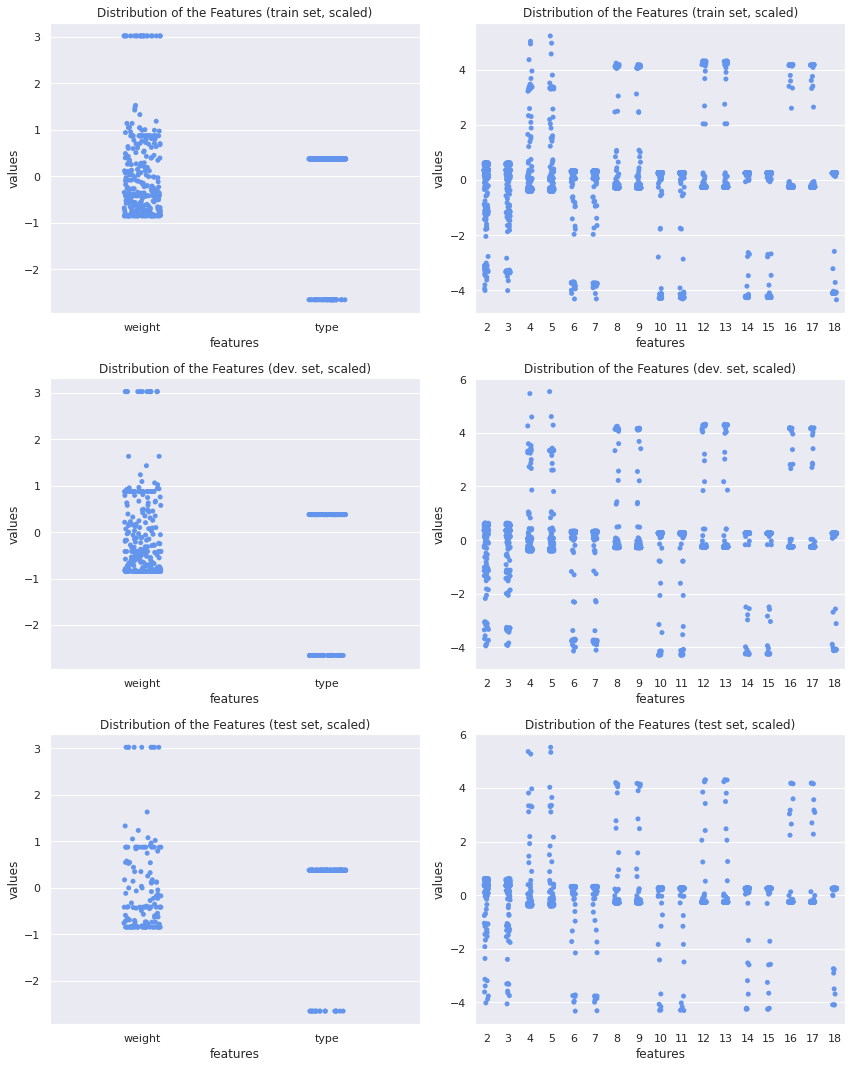

In [42]:
# build dataframes using the scaled data
train_slice_scl = pd.DataFrame(data = x_train, columns = train_slice.columns)
dev_slice_scl   = pd.DataFrame(data = x_dev,   columns = dev_slice.columns)
test_slice_scl  = pd.DataFrame(data = x_test,  columns = test_slice.columns)

# create a unique dataframe with all values in one column and all column types associated as a second column
cat_train_obs_types_post_scl = pd.concat([pd.DataFrame({'value': train_slice_scl[f].values, 'type': [f] * train_slice_scl[f].shape[0]}) for f in train_slice_scl.iloc[:,0:2]],
                                         axis = 0
                                        )
cat_train_lev_trunc_post_scl = pd.concat([pd.DataFrame({'value': train_slice_scl[f].values, 'type': [f] * train_slice_scl[f].shape[0]}) for f in train_slice_scl.iloc[:,2:]],
                                         axis = 0
                                        )
cat_dev_obs_types_post_scl   = pd.concat([pd.DataFrame({'value': dev_slice_scl[f].values, 'type': [f] * dev_slice_scl[f].shape[0]}) for f in dev_slice_scl.iloc[:,0:2]],
                                         axis = 0
                                        )
cat_dev_lev_trunc_post_scl   = pd.concat([pd.DataFrame({'value': dev_slice_scl[f].values, 'type': [f] * dev_slice_scl[f].shape[0]}) for f in dev_slice_scl.iloc[:,2:]],
                                         axis = 0
                                        )
cat_test_obs_types_post_scl  = pd.concat([pd.DataFrame({'value': test_slice_scl[f].values, 'type': [f] * test_slice_scl[f].shape[0]}) for f in test_slice_scl.iloc[:,0:2]],
                                         axis = 0
                                        )
cat_test_lev_trunc_post_scl  = pd.concat([pd.DataFrame({'value': test_slice_scl[f].values, 'type': [f] * test_slice_scl[f].shape[0]}) for f in test_slice_scl.iloc[:,2:]],
                                         axis = 0
                                        )

nrows = 3
ncols = 2
distrib_post_scl_fig, distrib_post_scl_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

sns.stripplot(data   = cat_train_obs_types_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_post_scl_plot[0,0]
             )
distrib_post_scl_plot[0,0].set(title = 'Distribution of the Features (train set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_train_lev_trunc_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = train_slice.columns[2:],
              ax     = distrib_post_scl_plot[0,1]
             )
distrib_post_scl_plot[0,1].set(title = 'Distribution of the Features (train set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_dev_obs_types_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_post_scl_plot[1,0]
             )
distrib_post_scl_plot[1,0].set(title = 'Distribution of the Features (dev. set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_dev_lev_trunc_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = dev_slice.columns[2:],
              ax     = distrib_post_scl_plot[1,1]
             )
distrib_post_scl_plot[1,1].set(title = 'Distribution of the Features (dev. set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_test_obs_types_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              ax     = distrib_post_scl_plot[2,0]
             )
distrib_post_scl_plot[2,0].set(title = 'Distribution of the Features (test set, scaled)', xlabel = 'features', ylabel = 'values')

sns.stripplot(data   = cat_test_lev_trunc_post_scl,
              x      = 'type',
              y      = 'value',
              color  = 'cornflowerblue',
              order  = test_slice.columns[2:],
              ax     = distrib_post_scl_plot[2,1]
             )
distrib_post_scl_plot[2,1].set(title = 'Distribution of the Features (test set, scaled)', xlabel = 'features', ylabel = 'values')

distrib_post_scl_fig.tight_layout()
distrib_post_scl_fig.savefig(path.join(IMG_PATH, 'distrib_post_scl.pdf'), dpi = 300, format = 'pdf')
distrib_post_scl_fig.savefig(path.join(IMG_PATH, 'distrib_post_scl.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(distrib_post_scl_fig)

As a summary we show the columns used for regression:

In [43]:
train_slice.columns

Index(['weight', 'type', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18'],
      dtype='object')

### Linear Regression

In [44]:
optimization = True #-------------------------------------------- choose whether to use optimisation

hyp_opt    = {'fit_intercept': [False, True]} #------------------ hypeparameter optimization
hyp_choice = {'fit_intercept': True} #--------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting LINEAR REGRESSION.')

if optimization:
    lin_reg_model, lin_reg_params, lin_reg_pred, lin_reg_mtr, lin_reg_cint = analysis.linear_regression(hyp_opt, optimization = optimization)
    print('Best hyperparameters:\n')
    pretty_print(lin_reg_params)
else:
    lin_reg_model, lin_reg_pred, lin_reg_mtr, lin_reg_cint = analysis.linear_regression(hyp_choice, optimization = optimization)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
    
print('Metrics:\n')
pretty_print(lin_reg_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(lin_reg_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

FIT INTERCEPT = True


Metrics:

MAE train SET = 0.2600934032653455
MAE dev SET = 0.28763681039008837
MAE test SET = 0.37702671993239384
MSE train SET = 0.13534932032132072
MSE dev SET = 0.1941653092846011
MSE test SET = 0.44032521591294427
R2 train SET = 0.7269447147082067
R2 dev SET = 0.6064373421685292
R2 test SET = 0.14072946792783814
EVR train SET = 0.7269447147082067
EVR dev SET = 0.6104815950005638
EVR test SET = 0.14168871425344787


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.08726944]), array([0.1834292]))
dev SET = (array([0.104483]), array([0.28384762]))
test SET = (array([0.12664976]), array([0.75400067]))




We then visualise the errors made on the development and test sets:

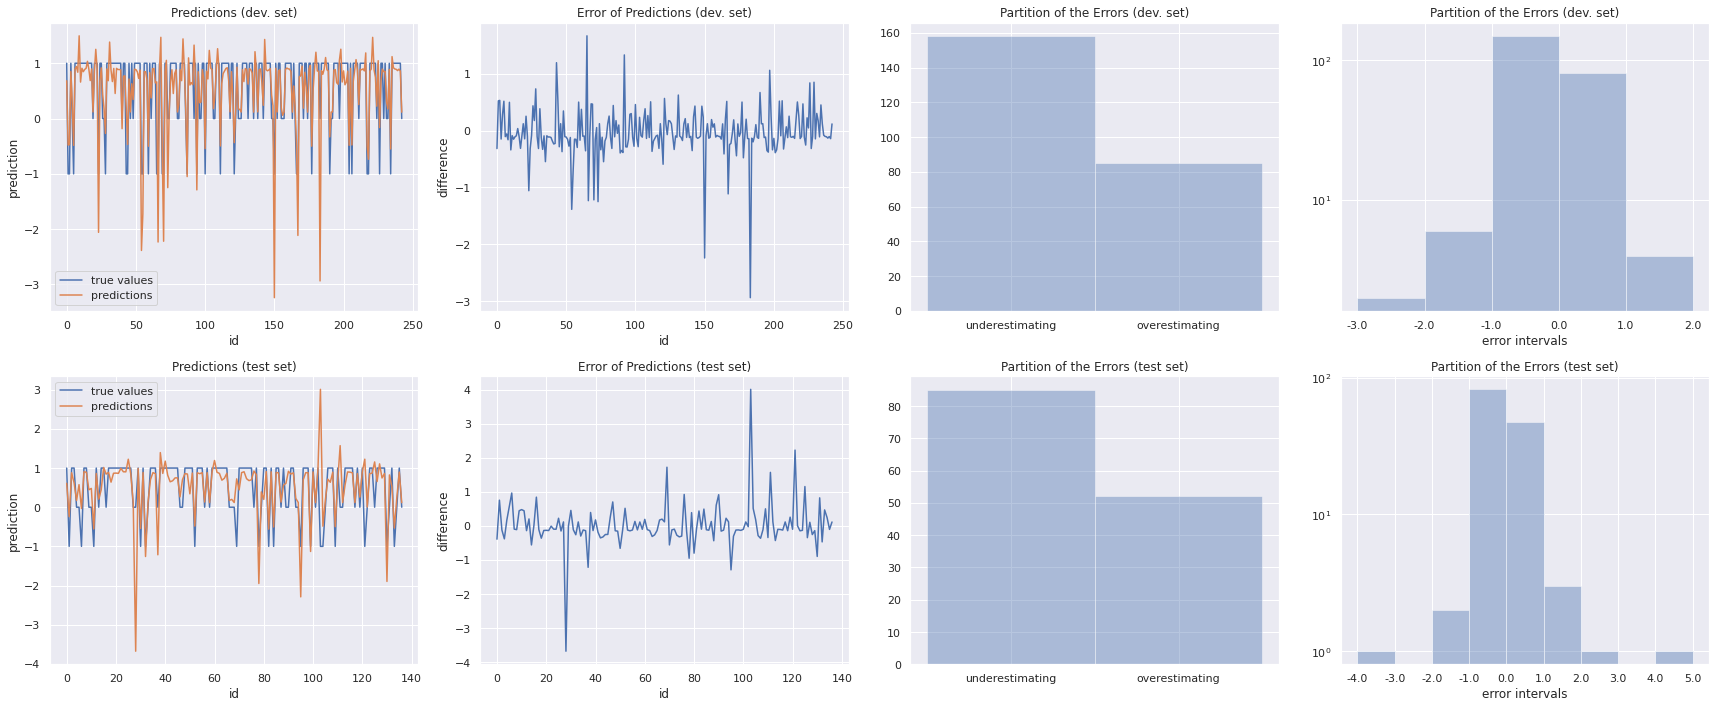

In [45]:
dev_length          = y_dev.shape[0]
test_length         = y_test.shape[0]
lin_reg_dev_errors  = lin_reg_pred['y_dev_pred'] - y_dev
lin_reg_test_errors = lin_reg_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
lin_reg_fig, lin_reg_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = lin_reg_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = lin_reg_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = lin_reg_plot[0,0]
            )
lin_reg_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = lin_reg_dev_errors.reshape(-1,),
             ax = lin_reg_plot[0,1]
            )
lin_reg_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(lin_reg_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = lin_reg_plot[0,2]
            )
lin_reg_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
lin_reg_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(lin_reg_dev_errors.min()), np.ceil(lin_reg_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(lin_reg_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = lin_reg_plot[0,3]
            )
lin_reg_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
lin_reg_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = lin_reg_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = lin_reg_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = lin_reg_plot[1,0]
            )
lin_reg_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = lin_reg_test_errors.reshape(-1,),
             ax = lin_reg_plot[1,1]
            )
lin_reg_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(lin_reg_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = lin_reg_plot[1,2]
            )
lin_reg_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
lin_reg_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(lin_reg_test_errors.min()), np.ceil(lin_reg_test_errors.max()) + n, 1)
sns.distplot(np.digitize(lin_reg_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = lin_reg_plot[1,3]
            )
lin_reg_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
lin_reg_plot[1,3].set_xticklabels(list(bins(1)))

lin_reg_fig.tight_layout()
lin_reg_fig.savefig(path.join(IMG_PATH, 'lin_reg.pdf'), dpi = 300, format = 'pdf')
lin_reg_fig.savefig(path.join(IMG_PATH, 'lin_reg.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(lin_reg_fig)

### Elastic Net

In [46]:
from skopt.space import Integer, Real

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(0, 1,                               name = 'fit_intercept'),
              Real(1.0e-4, 1.0e-2, prior = 'log-uniform', name = 'alpha'),
              Real(0.0, 1.0,                              name = 'l1_ratio')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'fit_intercept': True,
              'alpha':         1.0e-7,
              'l1_ratio':      0.1
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting ELASTIC NET.')

if optimization:
    el_net_model, el_net_params, el_net_pred, el_net_mtr, el_net_cint = analysis.elastic_net(hyp_opt, optimization = optimization, max_iter = 1e6, n_calls = 20)
    print('Best hyperparameters:\n')
    pretty_print(el_net_params)
else:
    el_net_model, el_net_pred, el_net_mtr, el_net_cint = analysis.elastic_net(hyp_choice, optimization = optimization, max_iter = 1e6)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(el_net_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(el_net_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

FIT INTERCEPT = 1
ALPHA         = 0.0001
L1 RATIO      = 1.0


Metrics:

MAE train SET = 0.35016431434354134
MAE dev SET = 0.34252290960726395
MAE test SET = 0.40665537034033056
MSE train SET = 0.2211353064851854
MSE dev SET = 0.19317200522515085
MSE test SET = 0.3057968309116508
R2 train SET = 0.5538790733706489
R2 dev SET = 0.6084507161698498
R2 test SET = 0.403254240031111
EVR train SET = 0.5538790733706489
EVR dev SET = 0.608734250711308
EVR test SET = 0.41804241287771526


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.15621453]), array([0.28605608]))
dev SET = (array([0.14890801]), array([0.237436]))
test SET = (array([0.19526488]), array([0.41632878]))




As in the previous context, we can visualise the errors in plots:

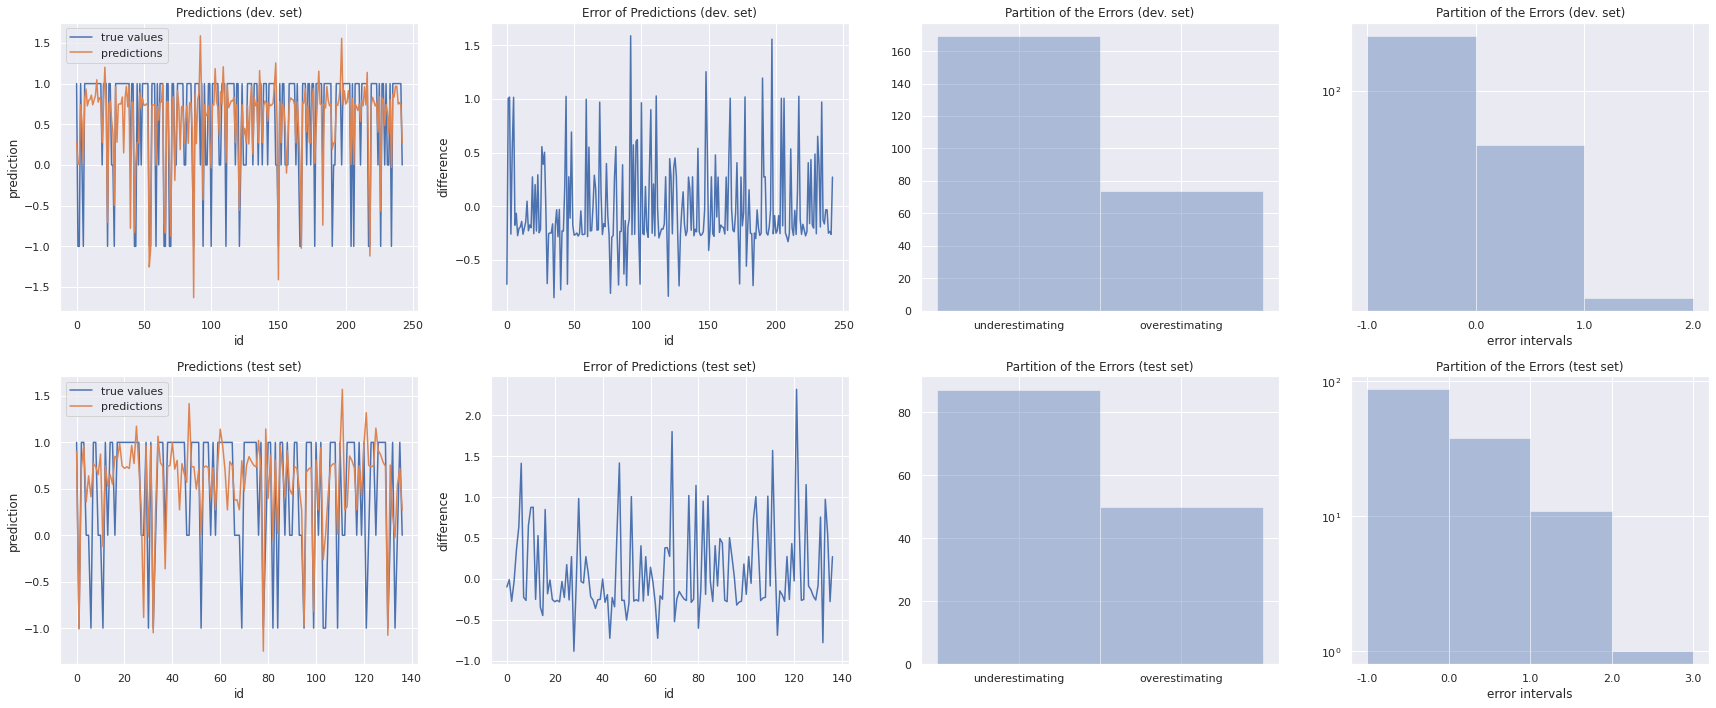

In [47]:
dev_length         = y_dev.shape[0]
test_length        = y_test.shape[0]
el_net_dev_errors  = el_net_pred['y_dev_pred'] - y_dev
el_net_test_errors = el_net_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
el_net_fig, el_net_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = el_net_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = el_net_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = el_net_plot[0,0]
            )
el_net_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = el_net_dev_errors.reshape(-1,),
             ax = el_net_plot[0,1]
            )
el_net_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(el_net_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = el_net_plot[0,2]
            )
el_net_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
el_net_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(el_net_dev_errors.min()), np.ceil(el_net_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(el_net_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = el_net_plot[0,3]
            )
el_net_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
el_net_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = el_net_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = el_net_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = el_net_plot[1,0]
            )
el_net_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = el_net_test_errors.reshape(-1,),
             ax = el_net_plot[1,1]
            )
el_net_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(el_net_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = el_net_plot[1,2]
            )
el_net_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
el_net_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(el_net_test_errors.min()), np.ceil(el_net_test_errors.max()) + n, 1)
sns.distplot(np.digitize(el_net_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = el_net_plot[1,3]
            )
el_net_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
el_net_plot[1,3].set_xticklabels(list(bins(1)))

el_net_fig.tight_layout()
el_net_fig.savefig(path.join(IMG_PATH, 'el_net.pdf'), dpi = 300, format = 'pdf')
el_net_fig.savefig(path.join(IMG_PATH, 'el_net.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(el_net_fig)

### Lasso

In [48]:
from skopt.space import Integer, Real

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(0, 1,                               name = 'fit_intercept'),
              Real(1.0e-1, 1.0e1, prior = 'log-uniform',  name = 'alpha')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'fit_intercept': True,
              'alpha':         1.0e-7
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting LASSO.')

if optimization:
    lasso_model, lasso_params, lasso_pred, lasso_mtr, lasso_cint = analysis.lasso(hyp_opt, optimization = optimization, max_iter = 1e6, n_calls = 20)
    print('Best hyperparameters:\n')
    pretty_print(lasso_params)
else:
    lasso_model, lasso_pred, lasso_mtr, lasso_cint = analysis.lasso(hyp_choice, optimization = optimization, max_iter = 1e6)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(lasso_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(lasso_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

FIT INTERCEPT = 1
ALPHA         = 0.1


Metrics:

MAE train SET = 0.4741011250490825
MAE dev SET = 0.4698954870293131
MAE test SET = 0.5038849452261713
MSE train SET = 0.3345823502294672
MSE dev SET = 0.3250795512971848
MSE test SET = 0.37701298906502206
R2 train SET = 0.32500969433302274
R2 dev SET = 0.3410812019584146
R2 test SET = 0.2642798095486171
EVR train SET = 0.32500969433302274
EVR dev SET = 0.3412954651334045
EVR test SET = 0.2744496443767295


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.2678005]), array([0.4013642]))
dev SET = (array([0.24861221]), array([0.40154689]))
test SET = (array([0.26554119]), array([0.48848479]))




And we show the error plot:

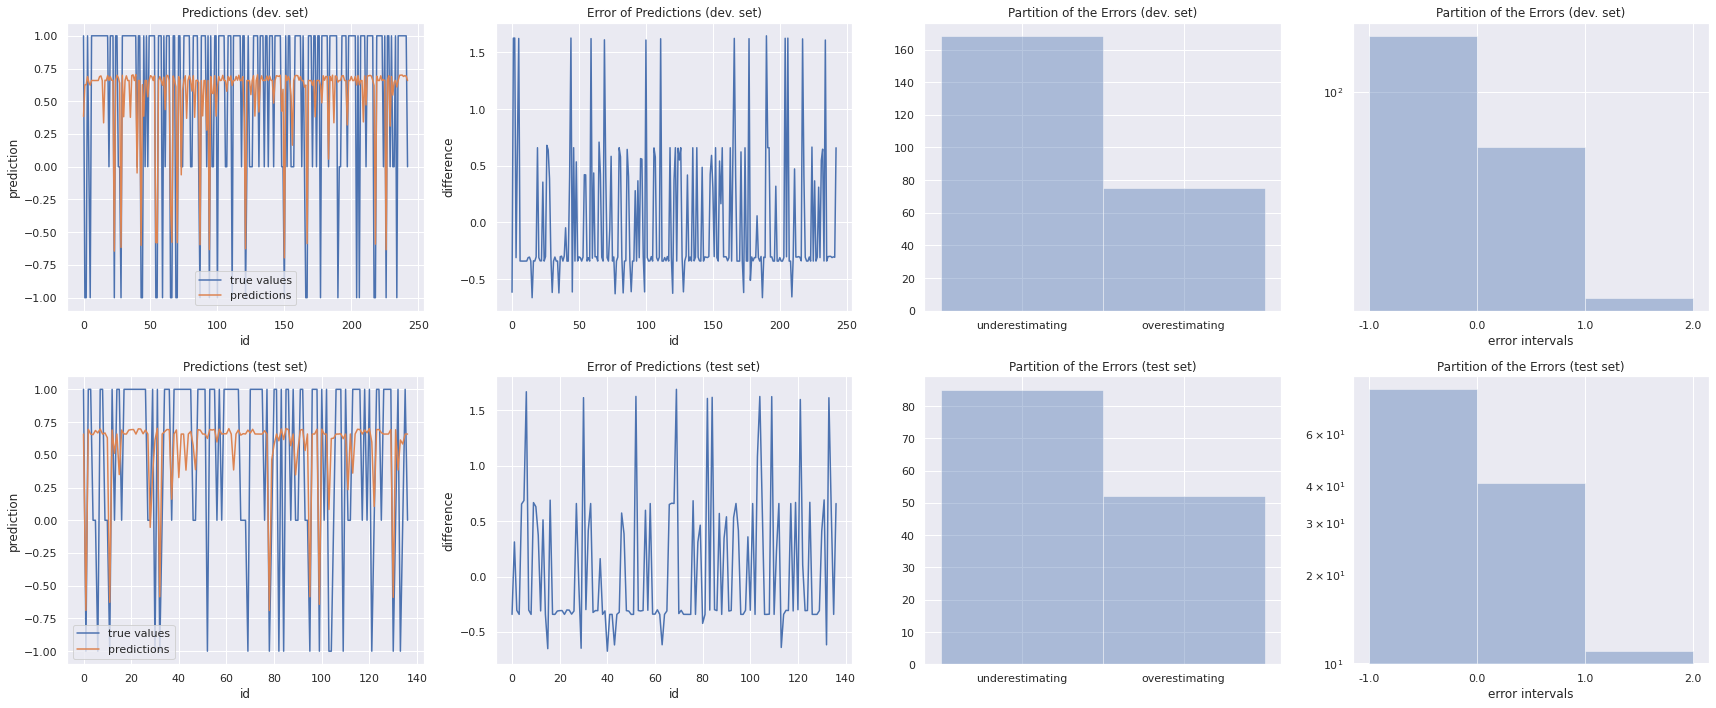

In [49]:
dev_length        = y_dev.shape[0]
test_length       = y_test.shape[0]
lasso_dev_errors  = lasso_pred['y_dev_pred'] - y_dev
lasso_test_errors = lasso_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
lasso_fig, lasso_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = lasso_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = lasso_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = lasso_plot[0,0]
            )
lasso_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = lasso_dev_errors.reshape(-1,),
             ax = lasso_plot[0,1]
            )
lasso_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(lasso_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = lasso_plot[0,2]
            )
lasso_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
lasso_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(lasso_dev_errors.min()), np.ceil(lasso_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(lasso_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = lasso_plot[0,3]
            )
lasso_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
lasso_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = lasso_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = lasso_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = lasso_plot[1,0]
            )
lasso_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = lasso_test_errors.reshape(-1,),
             ax = lasso_plot[1,1]
            )
lasso_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(lasso_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = lasso_plot[1,2]
            )
lasso_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
lasso_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(lasso_test_errors.min()), np.ceil(lasso_test_errors.max()) + n, 1)
sns.distplot(np.digitize(lasso_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = lasso_plot[1,3]
            )
lasso_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
lasso_plot[1,3].set_xticklabels(list(bins(1)))

lasso_fig.tight_layout()
lasso_fig.savefig(path.join(IMG_PATH, 'lasso.pdf'), dpi = 300, format = 'pdf')
lasso_fig.savefig(path.join(IMG_PATH, 'lasso.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(lasso_fig)

### Ridge

In [50]:
from skopt.space import Integer, Real

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(0, 1,                              name = 'fit_intercept'),
              Real(1.0e-1, 1.0e1, prior = 'log-uniform', name = 'alpha')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'fit_intercept': True,
              'alpha':         1.0e-7
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting RIDGE.')

if optimization:
    ridge_model, ridge_params, ridge_pred, ridge_mtr, ridge_cint = analysis.ridge(hyp_opt, optimization = optimization, n_calls = 20)
    print('Best hyperparameters:\n')
    pretty_print(ridge_params)
else:
    ridge_model, ridge_pred, ridge_mtr, ridge_cint = analysis.ridge(hyp_choice, optimization = optimization)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(ridge_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(ridge_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

FIT INTERCEPT = 1
ALPHA         = 0.1


Metrics:

MAE train SET = 0.3847673126256567
MAE dev SET = 0.3784404277426682
MAE test SET = 0.43674335071064957
MSE train SET = 0.26905824473478296
MSE dev SET = 0.24283212789321595
MSE test SET = 0.33739966872100774
R2 train SET = 0.4571987831061727
R2 dev SET = 0.5077923136081797
R2 test SET = 0.34158303366348564
EVR train SET = 0.4571987831061727
EVR dev SET = 0.5080573285476913
EVR test SET = 0.3610992885054417


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.20389304]), array([0.33422345]))
dev SET = (array([0.18771495]), array([0.2979493]))
test SET = (array([0.22117088]), array([0.45362845]))




And we show the error plot:

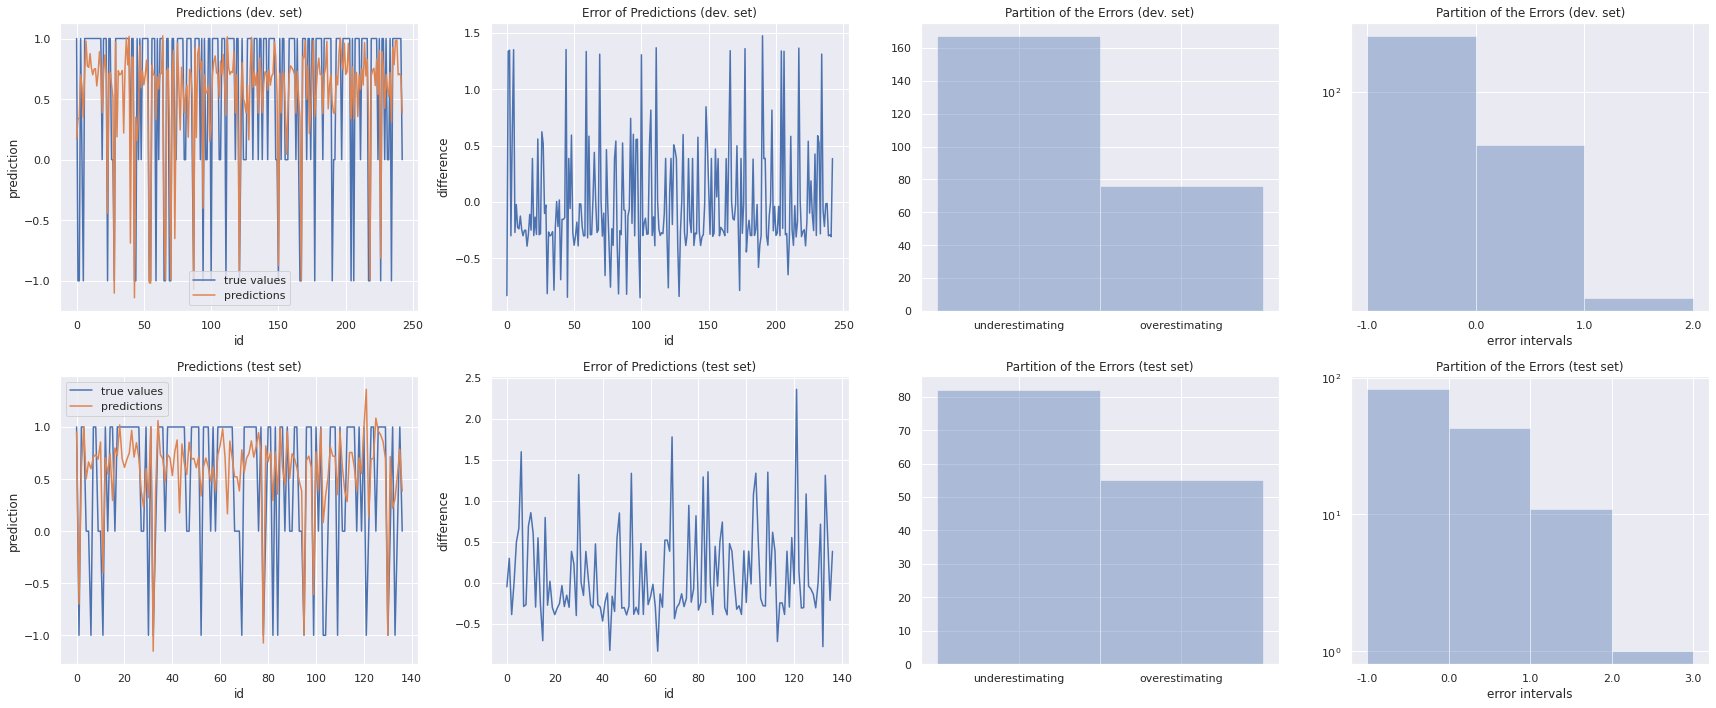

In [51]:
dev_length        = y_dev.shape[0]
test_length       = y_test.shape[0]
ridge_dev_errors  = ridge_pred['y_dev_pred'] - y_dev
ridge_test_errors = ridge_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
ridge_fig, ridge_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = ridge_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = ridge_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = ridge_plot[0,0]
            )
ridge_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = ridge_dev_errors.reshape(-1,),
             ax = ridge_plot[0,1]
            )
ridge_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(ridge_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = ridge_plot[0,2]
            )
ridge_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
ridge_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(ridge_dev_errors.min()), np.ceil(ridge_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(ridge_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = ridge_plot[0,3]
            )
ridge_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
ridge_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = ridge_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = ridge_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = ridge_plot[1,0]
            )
ridge_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = ridge_test_errors.reshape(-1,),
             ax = ridge_plot[1,1]
            )
ridge_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(ridge_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = ridge_plot[1,2]
            )
ridge_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
ridge_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(ridge_test_errors.min()), np.ceil(ridge_test_errors.max()) + n, 1)
sns.distplot(np.digitize(ridge_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = ridge_plot[1,3]
            )
ridge_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
ridge_plot[1,3].set_xticklabels(list(bins(1)))

ridge_fig.tight_layout()
ridge_fig.savefig(path.join(IMG_PATH, 'ridge.pdf'), dpi = 300, format = 'pdf')
ridge_fig.savefig(path.join(IMG_PATH, 'ridge.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(ridge_fig)

### Linear SVR

In [52]:
from skopt.space import Integer, Real, Categorical

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(0, 1,                                                       name = 'fit_intercept'),
              Real(1.0e-4, 1.0e-1, prior = 'log-uniform',                         name = 'epsilon'),
              Real(1.0e-4, 1.0e-1,  prior = 'log-uniform',                        name = 'C'),
              Real(1.0e-3, 1.0e1,  prior = 'log-uniform',                         name = 'intercept_scaling'),
              Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'], name = 'loss')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'fit_intercept':     True,
              'epsilon':           1.0e-7,
              'C':                 1.0e2,
              'loss':              'epsilon_insensitive',
              'intercept_scaling': 1.0e-2
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting LINEAR SVR.')

if optimization:
    lin_svr_model, lin_svr_params, lin_svr_pred, lin_svr_mtr, lin_svr_cint = analysis.linear_svr(hyp_opt, optimization = optimization, max_iter = 1e6, n_calls = 20)
    print('Best hyperparameters:\n')
    pretty_print(lin_svr_params)
else:
    lin_svr_model, lin_svr_pred, lin_svr_mtr, lin_svr_cint = analysis.linear_svr(hyp_choice, optimization = optimization, max_iter = 1e6)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(lin_svr_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(lin_svr_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

FIT INTERCEPT     = 1
EPSILON           = 0.1
C                 = 0.003245165936877118
INTERCEPT SCALING = 1.406188666667644
LOSS              = epsilon_insensitive


Metrics:

MAE train SET = 0.3606759311421946
MAE dev SET = 0.35575245107189346
MAE test SET = 0.4238738667836632
MSE train SET = 0.33826045687795636
MSE dev SET = 0.32350737599621215
MSE test SET = 0.41173562418011334
R2 train SET = 0.3175894394115162
R2 dev SET = 0.34426791688863345
R2 test SET = 0.19652048968220537
EVR train SET = 0.3449237934384207
EVR dev SET = 0.3665238474067902
EVR test SET = 0.26462569084524845


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.248149]), array([0.42837191]))
dev SET = (array([0.22058479]), array([0.42642996]))
test SET = (array([0.26208097]), array([0.56139028]))




And we show the error plot:

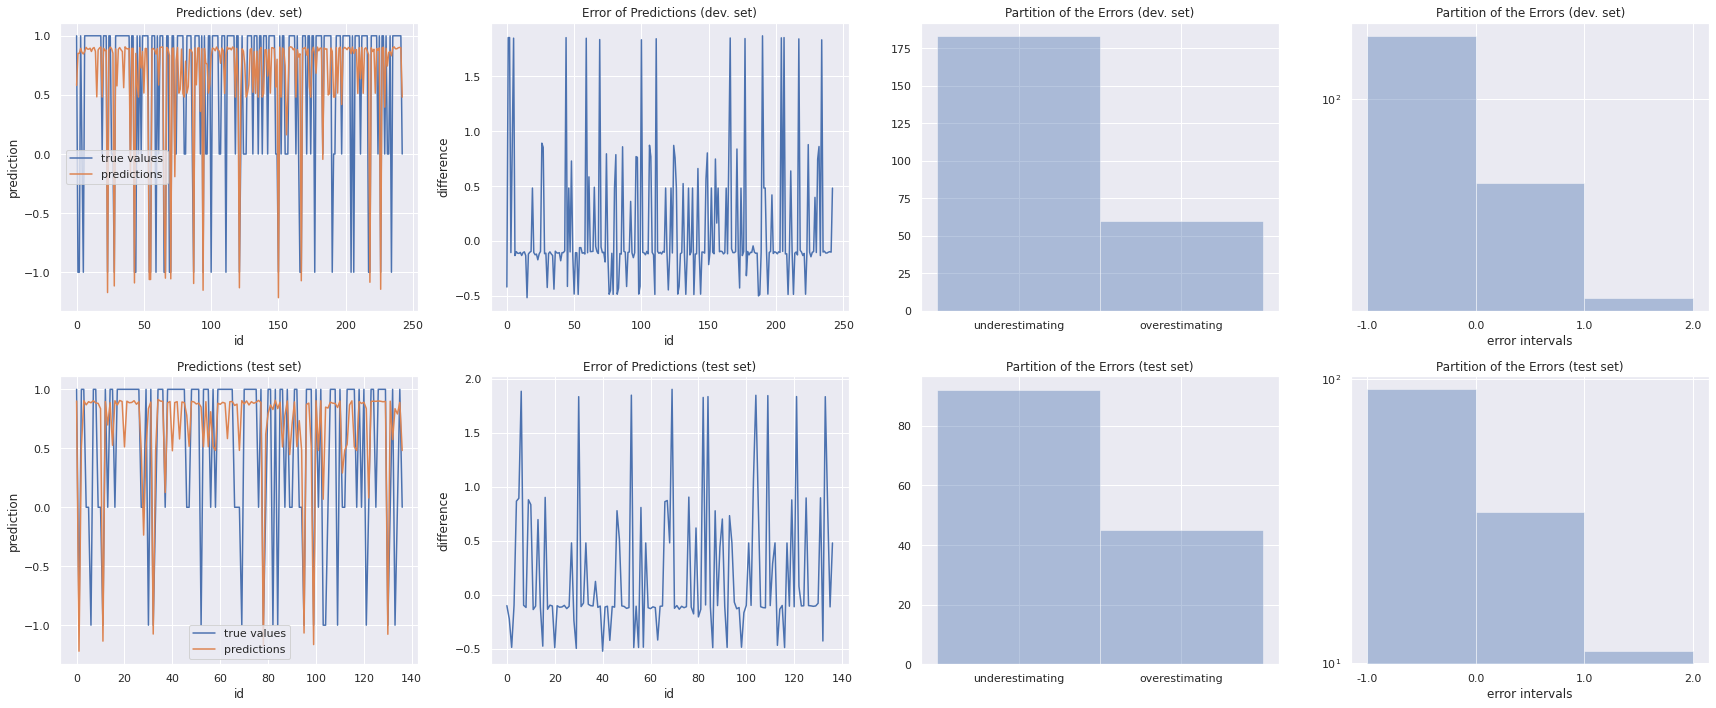

In [53]:
dev_length          = y_dev.shape[0]
test_length         = y_test.shape[0]
lin_svr_dev_errors  = lin_svr_pred['y_dev_pred'] - y_dev
lin_svr_test_errors = lin_svr_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
lin_svr_fig, lin_svr_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = lin_svr_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = lin_svr_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = lin_svr_plot[0,0]
            )
lin_svr_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = lin_svr_dev_errors.reshape(-1,),
             ax = lin_svr_plot[0,1]
            )
lin_svr_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(lin_svr_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = lin_svr_plot[0,2]
            )
lin_svr_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
lin_svr_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(lin_svr_dev_errors.min()), np.ceil(lin_svr_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(lin_svr_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = lin_svr_plot[0,3]
            )
lin_svr_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
lin_svr_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = lin_svr_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = lin_svr_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = lin_svr_plot[1,0]
            )
lin_svr_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = lin_svr_test_errors.reshape(-1,),
             ax = lin_svr_plot[1,1]
            )
lin_svr_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(lin_svr_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = lin_svr_plot[1,2]
            )
lin_svr_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
lin_svr_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(lin_svr_test_errors.min()), np.ceil(lin_svr_test_errors.max()) + n, 1)
sns.distplot(np.digitize(lin_svr_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = lin_svr_plot[1,3]
            )
lin_svr_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
lin_svr_plot[1,3].set_xticklabels(list(bins(1)))

lin_svr_fig.tight_layout()
lin_svr_fig.savefig(path.join(IMG_PATH, 'lin_svr.pdf'), dpi = 300, format = 'pdf')
lin_svr_fig.savefig(path.join(IMG_PATH, 'lin_svr.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(lin_svr_fig)

### SVR (w/ Gaussian kernel)

In [54]:
from skopt.space import Integer, Real, Categorical

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Real(1.0e-5, 1.0e-1, prior = 'log-uniform', name = 'gamma'),
              Real(1.0e-3, 1.0e-1, prior = 'log-uniform', name = 'epsilon'),
              Real(1.0e-2, 1.0e2, prior = 'log-uniform', name = 'C')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'epsilon': 1.0e-7,
              'C':       1.0e2,
              'gamma':   1.0e-2
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting SVR (GAUSSIAN KERNEL).')

if optimization:
    svr_rbf_model, svr_rbf_params, svr_rbf_pred, svr_rbf_mtr, svr_rbf_cint = analysis.svr_rbf(hyp_opt, optimization = optimization, n_calls = 20)
    print('Best hyperparameters:\n')
    pretty_print(svr_rbf_params)
else:
    svr_rbf_model, svr_rbf_pred, svr_rbf_mtr, svr_rbf_cint = analysis.svr_rbf(hyp_choice, optimization = optimization)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(svr_rbf_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(svr_rbf_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

GAMMA   = 0.09759577447126233
EPSILON = 0.1
C       = 99.99530715399911


Metrics:

MAE train SET = 0.1236620003641686
MAE dev SET = 0.11880836810085596
MAE test SET = 0.20797610962146407
MSE train SET = 0.05661498682223381
MSE dev SET = 0.03672713787119192
MSE test SET = 0.16601943392146848
R2 train SET = 0.885784270347008
R2 dev SET = 0.9255560632927361
R2 test SET = 0.676022171421081
EVR train SET = 0.8866938656162804
EVR dev SET = 0.9255568738568754
EVR test SET = 0.6801619865882518


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.01947232]), array([0.09375765]))
dev SET = (array([0.0195898]), array([0.05386448]))
test SET = (array([0.06779474]), array([0.26424413]))




And we show the error plot:

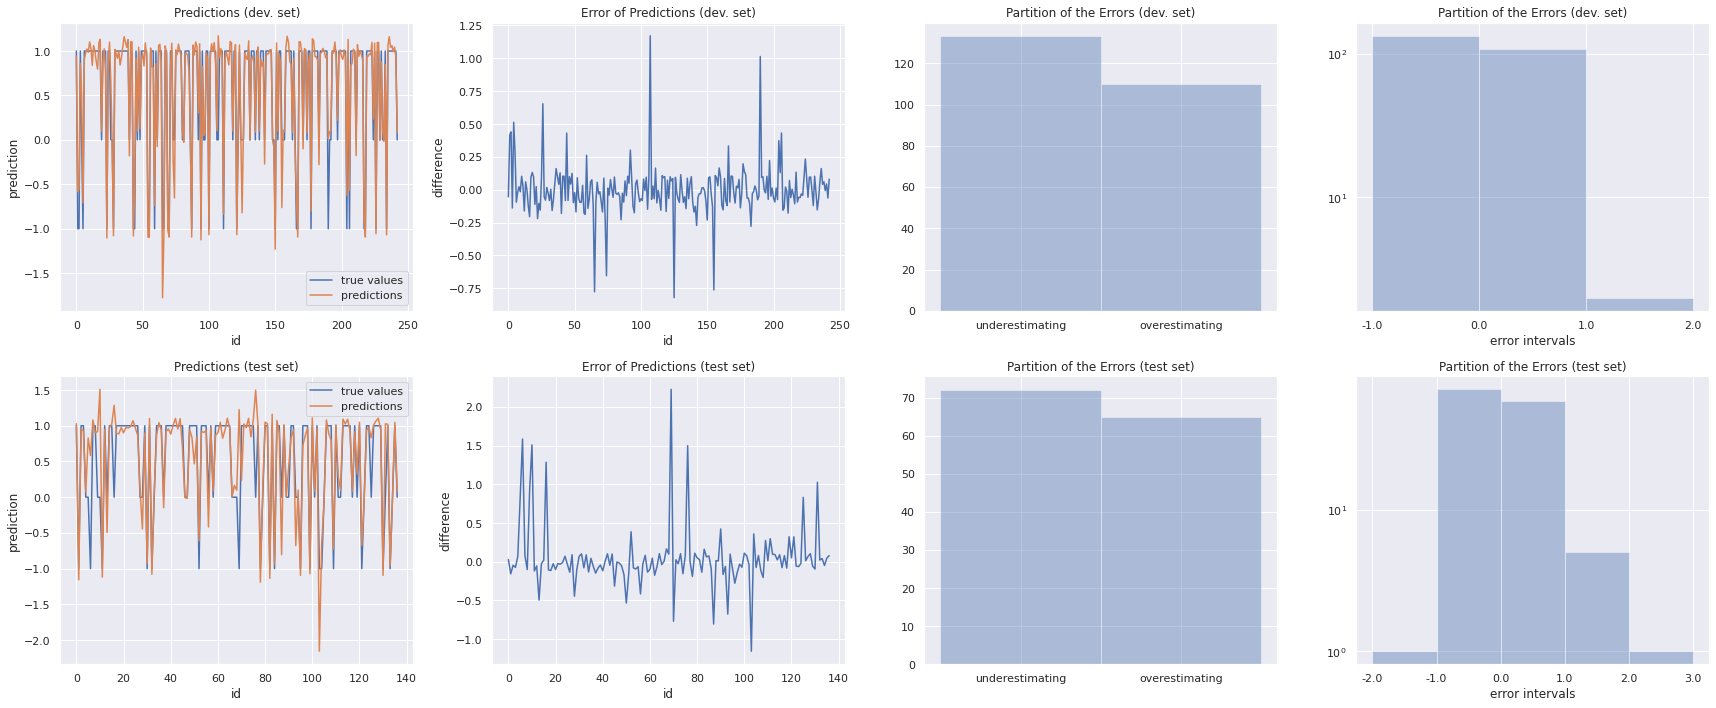

In [55]:
dev_length          = y_dev.shape[0]
test_length         = y_test.shape[0]
svr_rbf_dev_errors  = svr_rbf_pred['y_dev_pred'] - y_dev
svr_rbf_test_errors = svr_rbf_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
svr_rbf_fig, svr_rbf_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = svr_rbf_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = svr_rbf_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = svr_rbf_plot[0,0]
            )
svr_rbf_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = svr_rbf_dev_errors.reshape(-1,),
             ax = svr_rbf_plot[0,1]
            )
svr_rbf_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(svr_rbf_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = svr_rbf_plot[0,2]
            )
svr_rbf_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
svr_rbf_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(svr_rbf_dev_errors.min()), np.ceil(svr_rbf_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(svr_rbf_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = svr_rbf_plot[0,3]
            )
svr_rbf_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
svr_rbf_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = svr_rbf_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = svr_rbf_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = svr_rbf_plot[1,0]
            )
svr_rbf_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = svr_rbf_test_errors.reshape(-1,),
             ax = svr_rbf_plot[1,1]
            )
svr_rbf_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(svr_rbf_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = svr_rbf_plot[1,2]
            )
svr_rbf_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
svr_rbf_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(svr_rbf_test_errors.min()), np.ceil(svr_rbf_test_errors.max()) + n, 1)
sns.distplot(np.digitize(svr_rbf_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = svr_rbf_plot[1,3]
            )
svr_rbf_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
svr_rbf_plot[1,3].set_xticklabels(list(bins(1)))

svr_rbf_fig.tight_layout()
svr_rbf_fig.savefig(path.join(IMG_PATH, 'svr_rbf.pdf'), dpi = 300, format = 'pdf')
svr_rbf_fig.savefig(path.join(IMG_PATH, 'svr_rbf.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(svr_rbf_fig)

### Random Forests

In [56]:
from skopt.space import Integer, Real, Categorical

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(2, 100,                             name = 'num_leaves'),
              Integer(50, 300,                            name = 'max_depth'),
              Integer(2, 50,                              name = 'n_estimators'),
              Real(0.1, 0.99,                             name = 'subsample'),
              Real(0.1, 1.0,                              name = 'colsample_bytrees'),
              Real(1.0e-6, 1.0e-2, prior = 'log-uniform', name = 'min_child_weight'),
              Real(1.0e-1, 1.0e2,  prior = 'log-uniform', name = 'reg_alpha'),
              Real(1.0e-1, 1.0e2,  prior = 'log-uniform', name = 'reg_lambda')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'num_leaves':        15,
              'max_depth':         45,
              'n_estimators':      15,
              'min_child_weight':  1.0e-2,
              'subsample':         0.9,
              'colsample_bytrees': 0.9,
              'reg_alpha':         1.0e-3,
              'reg_lambda':        1.0e-3
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting RANDOM FOREST.')

if optimization:
    rnd_for_model, rnd_for_params, rnd_for_pred, rnd_for_mtr, rnd_for_cint = analysis.random_forest(hyp_opt, optimization = optimization, n_calls = 15)
    print('Best hyperparameters:\n')
    pretty_print(rnd_for_params)
else:
    rnd_for_model, rnd_for_pred, rnd_for_mtr, rnd_for_cint = analysis.random_forest(hyp_choice, optimization = optimization)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(rnd_for_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(rnd_for_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

NUM LEAVES        = 100
MAX DEPTH         = 50
N ESTIMATORS      = 50
SUBSAMPLE         = 0.99
COLSAMPLE BYTREES = 0.1
MIN CHILD WEIGHT  = 1e-06
REG ALPHA         = 4.903754841543907
REG LAMBDA        = 0.1


Metrics:

MAE train SET = 0.16536797470436582
MAE dev SET = 0.1514034129067892
MAE test SET = 0.1995570474869497
MSE train SET = 0.05690186452543687
MSE dev SET = 0.041128212464082464
MSE test SET = 0.0790235983979207
R2 train SET = 0.8852055199483655
R2 dev SET = 0.9166353213719757
R2 test SET = 0.845789777674093
EVR train SET = 0.885949757547139
EVR dev SET = 0.9167409376845786
EVR test SET = 0.8471908228446716


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.04172563]), array([0.0720781]))
dev SET = (array([0.03254822]), array([0.04970821]))
test SET = (array([0.04953758]), array([0.10850961]))




We then plot the errors:

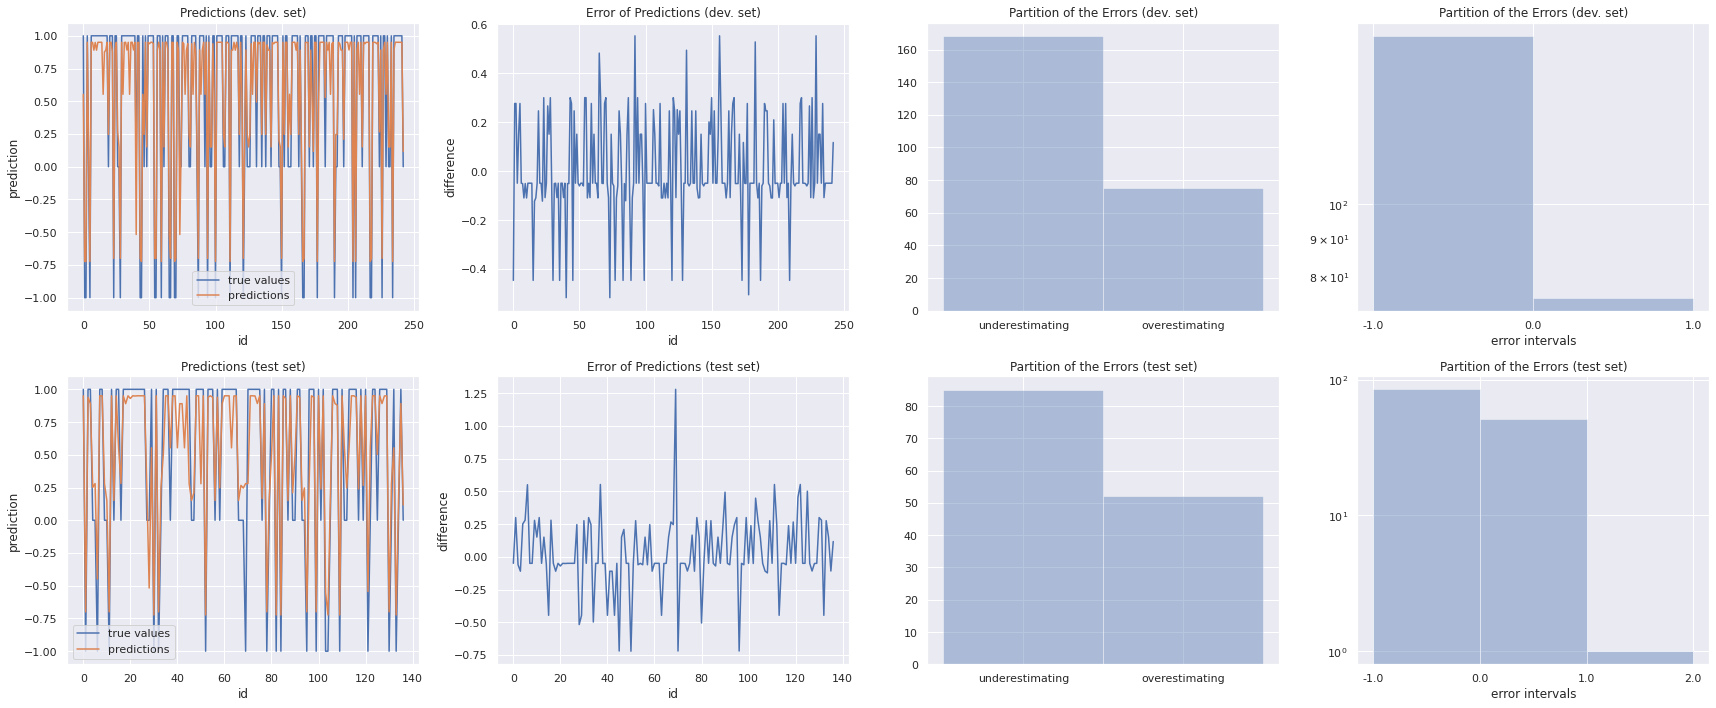

In [57]:
dev_length        = y_dev.shape[0]
test_length       = y_test.shape[0]
rnd_for_dev_errors  = rnd_for_pred['y_dev_pred'] - y_dev
rnd_for_test_errors = rnd_for_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
rnd_for_fig, rnd_for_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = rnd_for_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = rnd_for_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = rnd_for_plot[0,0]
            )
rnd_for_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = rnd_for_dev_errors.reshape(-1,),
             ax = rnd_for_plot[0,1]
            )
rnd_for_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(rnd_for_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = rnd_for_plot[0,2]
            )
rnd_for_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
rnd_for_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(rnd_for_dev_errors.min()), np.ceil(rnd_for_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(rnd_for_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = rnd_for_plot[0,3]
            )
rnd_for_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
rnd_for_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = rnd_for_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = rnd_for_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = rnd_for_plot[1,0]
            )
rnd_for_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = rnd_for_test_errors.reshape(-1,),
             ax = rnd_for_plot[1,1]
            )
rnd_for_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(rnd_for_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = rnd_for_plot[1,2]
            )
rnd_for_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
rnd_for_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(rnd_for_test_errors.min()), np.ceil(rnd_for_test_errors.max()) + n, 1)
sns.distplot(np.digitize(rnd_for_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = rnd_for_plot[1,3]
            )
rnd_for_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
rnd_for_plot[1,3].set_xticklabels(list(bins(1)))

rnd_for_fig.tight_layout()
rnd_for_fig.savefig(path.join(IMG_PATH, 'rnd_for.pdf'), dpi = 300, format = 'pdf')
rnd_for_fig.savefig(path.join(IMG_PATH, 'rnd_for.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(rnd_for_fig)

### Gradient Boosted Trees

In [58]:
from skopt.space import Integer, Real, Categorical

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(2, 25,                              name = 'num_leaves'),
              Integer(2, 25,                              name = 'max_depth'),
              Integer(1e1, 4e3,    prior = 'log-uniform', name = 'n_estimators'),
              Real(0.1, 0.99,                             name = 'subsample'),
              Real(0.1, 1.0,                              name = 'colsample_bytrees'),
              Real(1.0e-3, 1.0e-1, prior = 'log-uniform', name = 'min_child_weight'),
              Real(1.0e0, 1.0e2,  prior = 'log-uniform',  name = 'reg_alpha'),
              Real(1.0e0, 1.0e3,   prior = 'log-uniform', name = 'reg_lambda')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'num_leaves':        15,
              'max_depth':         45,
              'n_estimators':      500,
              'min_child_weight':  1.0e-2,
              'subsample':         0.9,
              'colsample_bytrees': 0.9,
              'reg_alpha':         1.0e-3,
              'reg_lambda':        1.0e-3
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting BOOSTED TREES.')

if optimization:
    grd_boost_model, grd_boost_params, grd_boost_pred, grd_boost_mtr, grd_boost_cint = analysis.gradient_boosting(hyp_opt, optimization = optimization, n_calls = 15)
    print('Best hyperparameters:\n')
    pretty_print(grd_boost_params)
else:
    grd_boost_model, grd_boost_pred, grd_boost_mtr, grd_boost_cint = analysis.gradient_boosting(hyp_choice, optimization = optimization)
    print('Hyperparameters:\n')
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(grd_boost_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(grd_boost_cint)
    
log.debug('End of the fit.')

Best hyperparameters:

NUM LEAVES        = 2
MAX DEPTH         = 2
N ESTIMATORS      = 3155
SUBSAMPLE         = 0.46491323949305663
COLSAMPLE BYTREES = 0.5934978649691239
MIN CHILD WEIGHT  = 0.019231946757274753
REG ALPHA         = 1.9325215190156115
REG LAMBDA        = 1.5117245053053598


Metrics:

MAE train SET = 0.13211797350833937
MAE dev SET = 0.12423001562800762
MAE test SET = 0.16713200901022082
MSE train SET = 0.04542896826471898
MSE dev SET = 0.03499477638833234
MSE test SET = 0.06454515904818178
R2 train SET = 0.9083510736471674
R2 dev SET = 0.9290674670137774
R2 test SET = 0.8740436587465872
EVR train SET = 0.9084538823434102
EVR dev SET = 0.9292009690852772
EVR test SET = 0.8743407603620406


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.03088493]), array([0.05997301]))
dev SET = (array([0.02573476]), array([0.04425479]))
test SET = (array([0.03826312]), array([0.09082719]))




We then plot the errors:

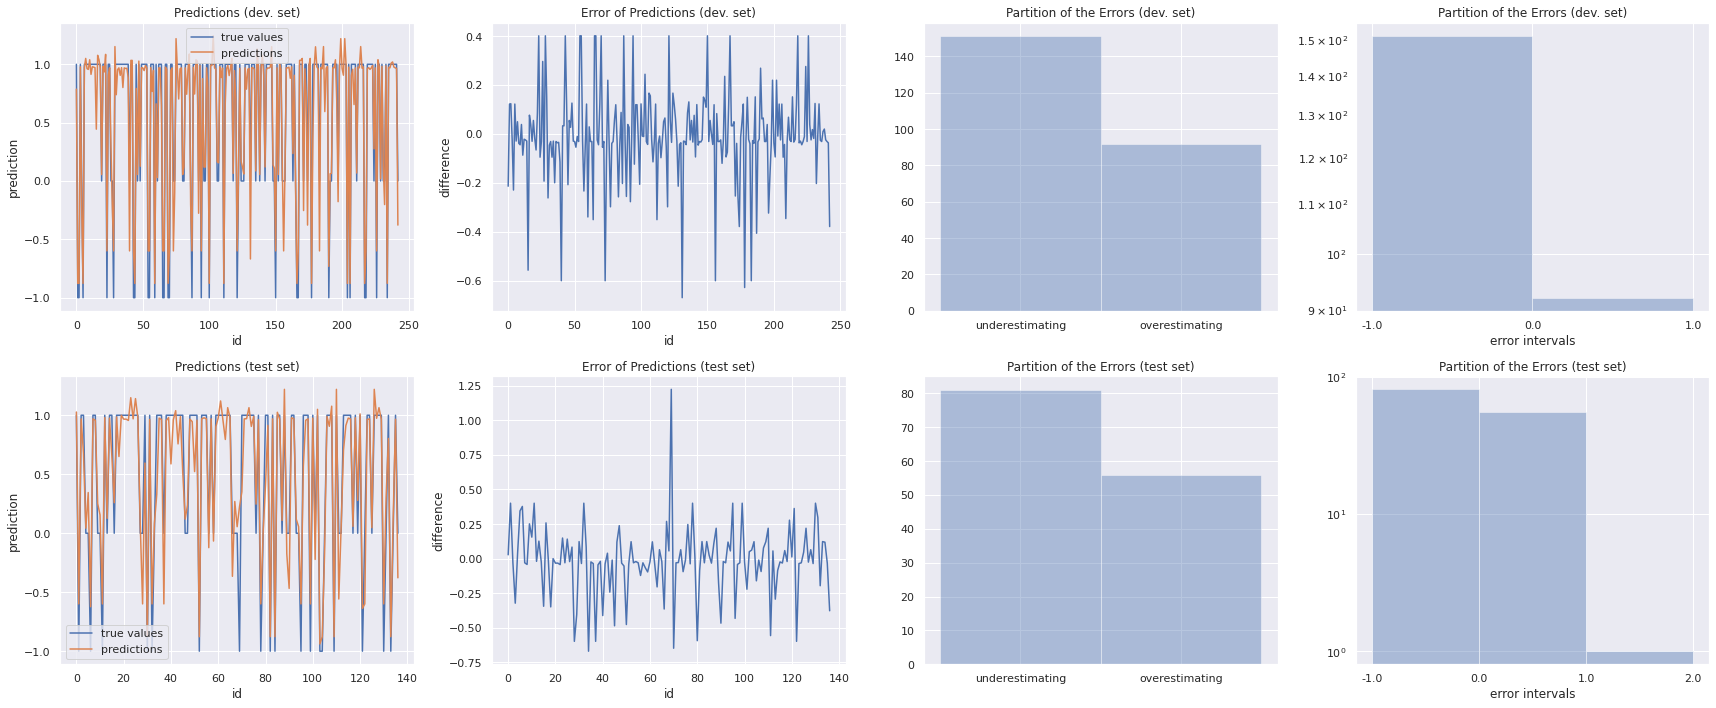

In [59]:
dev_length            = y_dev.shape[0]
test_length           = y_test.shape[0]
grd_boost_dev_errors  = grd_boost_pred['y_dev_pred'] - y_dev
grd_boost_test_errors = grd_boost_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
grd_boost_fig, grd_boost_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = grd_boost_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = grd_boost_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = grd_boost_plot[0,0]
            )
grd_boost_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = grd_boost_dev_errors.reshape(-1,),
             ax = grd_boost_plot[0,1]
            )
grd_boost_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(grd_boost_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = grd_boost_plot[0,2]
            )
grd_boost_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
grd_boost_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(grd_boost_dev_errors.min()), np.ceil(grd_boost_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(grd_boost_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = grd_boost_plot[0,3]
            )
grd_boost_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
grd_boost_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = grd_boost_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = grd_boost_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = grd_boost_plot[1,0]
            )
grd_boost_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = grd_boost_test_errors.reshape(-1,),
             ax = grd_boost_plot[1,1]
            )
grd_boost_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(grd_boost_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = grd_boost_plot[1,2]
            )
grd_boost_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
grd_boost_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(grd_boost_test_errors.min()), np.ceil(grd_boost_test_errors.max()) + n, 1)
sns.distplot(np.digitize(grd_boost_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = grd_boost_plot[1,3]
            )
grd_boost_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
grd_boost_plot[1,3].set_xticklabels(list(bins(1)))

grd_boost_fig.tight_layout()
grd_boost_fig.savefig(path.join(IMG_PATH, 'grd_boost.pdf'), dpi = 300, format = 'pdf')
grd_boost_fig.savefig(path.join(IMG_PATH, 'grd_boost.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(grd_boost_fig)

### Artificial Neural Networks

In [60]:
from skopt.space import Integer, Real, Categorical

optimization = True #--------------------------------------------------------- choose whether to use optimisation

hyp_opt    = [Integer(0, 1,                               name = 'dropout'),
              Integer(0, 1,                               name = 'batch_normalization'),
              Integer(2, 100,                             name = 'n_layers'),
              Integer(2, 50,                              name = 'n_units'),
              Real(0.1, 0.999,                            name = 'momentum'),
              Real(1.0e-4, 1.0e-2, prior = 'log-uniform', name = 'learning_rate'),
              Real(1.0e-3, 1.0e-1, prior = 'log-uniform', name = 'slope'),
              Real(1.0e-2, 5.0e-1, prior = 'log-uniform', name = 'dropout_rate'),
              Real(1.0e-1, 1.0e1,  prior = 'log-uniform', name = 'l1_reg'),
              Real(1.0e-1, 1.0e1,  prior = 'log-uniform', name = 'l2_reg'),
              Categorical(['relu', 'leaky'],              name = 'activation')
             ] #-------------------------------------------------------------- hypeparameter optimization
hyp_choice = {'n_layers':            10,
              'n_units':             10,
              'learning_rate':       0.01,
              'activation':          'relu',
              'slope':               0.3,
              'dropout':             True,
              'dropout_rate':        0.2,
              'batch_normalization': True,
              'momentum':            0.99
             } #-------------------------------------------------------------- a choice of hyperparameters (use if optimization = False)

log.info('Fitting ARTIFICIAL NEURAL NETWORK.')

n_epochs = 15000
if optimization:
    ann_model, ann_history, ann_params, ann_model_pred, ann_mtr, ann_cint = analysis.ann_model(hyp_opt, batch_size = x_train.shape[0], epochs = n_epochs, filename = path.join(MOD_PATH, 'ann_model.h5'), verbose = 0, optimization = optimization, n_calls = 15)
    print('Best hyperparameters:\n')
    pretty_print(ann_params)
else:
    ann_model, ann_history, ann_model_pred, ann_mtr, ann_cint = analysis.ann_model(hyp_choice, batch_size = x_train.shape[0], epochs = n_epochs, filename = path.join(MOD_PATH, 'ann_model.h5'), verbose = 0, optimization = optimization)
    print('Hyperparameters:\n')
    ann_params = hyp_choice
    pretty_print(hyp_choice)
        
print('Metrics:\n')
pretty_print(ann_mtr)

print('Confidence intervals of the MSE (CI 95%):\n')
pretty_print(ann_cint)
    
log.debug('End of the fit.')

Hyperparameters:

N LAYERS            = 10
N UNITS             = 10
LEARNING RATE       = 0.01
ACTIVATION          = relu
SLOPE               = 0.3
DROPOUT             = True
DROPOUT RATE        = 0.2
BATCH NORMALIZATION = True
MOMENTUM            = 0.99


Metrics:

MAE train SET = 0.23363522188903313
MAE dev SET = 0.22394381972497382
MAE test SET = 0.28508513252230455
MSE train SET = 0.12112721697919608
MSE dev SET = 0.10451140200998667
MSE test SET = 0.18758165345861894
R2 train SET = 0.755636550591194
R2 dev SET = 0.7881609989946553
R2 test SET = 0.633944681455103
EVR train SET = 0.7567168580043685
EVR dev SET = 0.7885615342519542
EVR test SET = 0.6491413291283659


Confidence intervals of the MSE (CI 95%):

train SET = (array([0.08805853]), array([0.1541959]))
dev SET = (array([0.07718148]), array([0.13184132]))
test SET = (array([0.1047639]), array([0.27039941]))




We can take a look at the training and validation history:

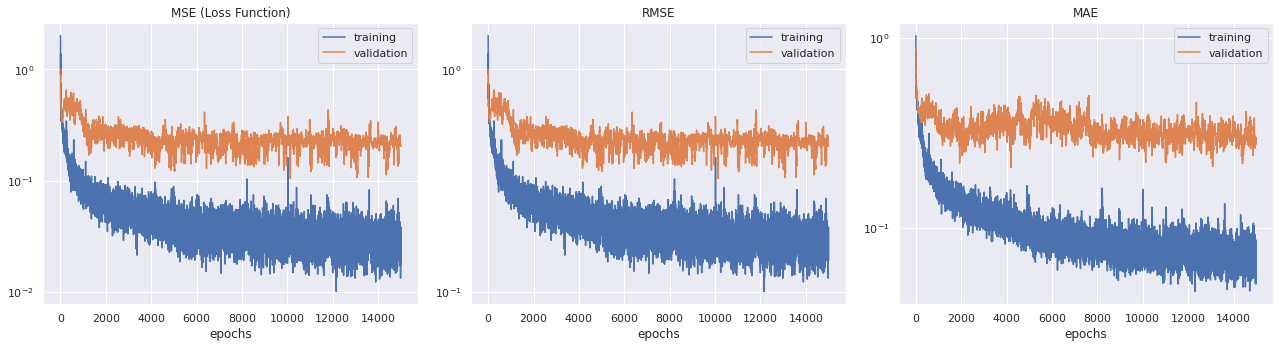

In [61]:
nrows = 1
ncols = 3
ann_model_fig, ann_model_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

sns.lineplot(data  = ann_history,
             x     = range(n_epochs),
             y     = 'mean_squared_error',
             label = 'training',
             ax    = ann_model_plot[0]
            )
sns.lineplot(data  = ann_history,
             x     = range(n_epochs),
             y     = 'val_mean_squared_error',
             label = 'validation',
             ax    = ann_model_plot[0]
            )
ann_model_plot[0].set(title = 'MSE (Loss Function)', xlabel = 'epochs', yscale = 'log')

sns.lineplot(data  = ann_history,
             x     = range(n_epochs),
             y     = 'root_mean_squared_error',
             label = 'training',
             ax    = ann_model_plot[1]
            )
sns.lineplot(data  = ann_history,
             x     = range(n_epochs),
             y     = 'val_root_mean_squared_error',
             label = 'validation',
             ax    = ann_model_plot[1]
            )
ann_model_plot[1].set(title = 'RMSE', xlabel = 'epochs', yscale = 'log')

sns.lineplot(data  = ann_history,
             x     = range(n_epochs),
             y     = 'mean_absolute_error',
             label = 'training',
             ax    = ann_model_plot[2]
            )
sns.lineplot(data  = ann_history,
             x     = range(n_epochs),
             y     = 'val_mean_absolute_error',
             label = 'validation',
             ax    = ann_model_plot[2]
            )
ann_model_plot[2].set(title = 'MAE', xlabel = 'epochs', yscale = 'log')

ann_model_fig.tight_layout()
ann_model_fig.savefig(path.join(IMG_PATH, 'ann_model_history.pdf'), dpi = 300, format = 'pdf')
ann_model_fig.savefig(path.join(IMG_PATH, 'ann_model_history.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(ann_model_fig)

The same plots can also be smoothen using a running average to better understand the behaviour:

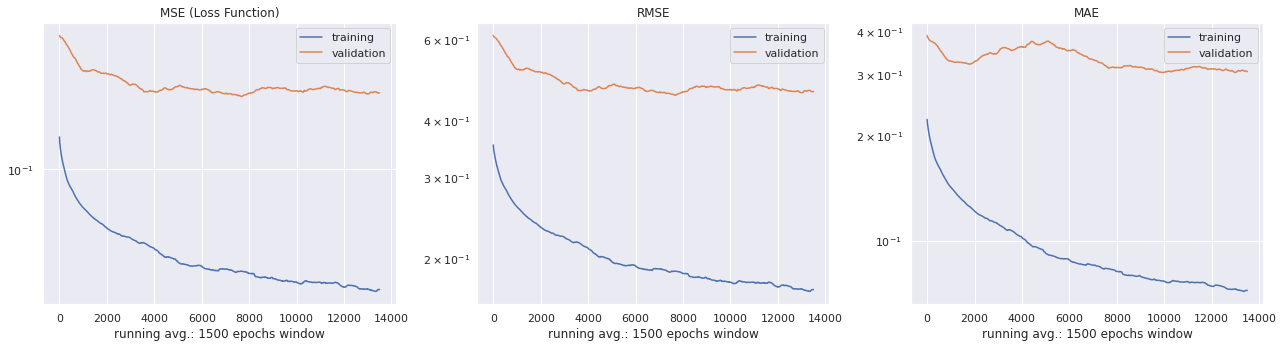

In [62]:
def running_average(values, window):
    '''
    Compute the (simple) running average of a series of data.
    
    Required arguments:
        values: list of values,
        window: temporal window for the computation.
    '''
    values  = np.reshape(values, (-1,1)) #------------------------ reshape the list to a n x 1 column vector
    run_avg = np.zeros((np.shape(values)[0] - window + 1, 1)) #--- the no. of valid averages is n - window + 1
    
    for i in range(run_avg.shape[0]):
        run_avg[i,:] = np.sum(values[i:i + window,:]) / window #-- take 'window' values and compute their average
    
    return run_avg #---------------------------------------------- return the running averages

# select a "time" window
win  = int(np.shape(ann_history['loss'])[0] / 10)
ann_history_running_avg = {f: running_average(ann_history[f], win).reshape(-1,) for f in ann_history}

nrows = 1
ncols = 3
ann_model_running_avg_fig, ann_model_running_avg_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

sns.lineplot(data  = ann_history_running_avg,
             x     = range(n_epochs - win + 1),
             y     = 'mean_squared_error',
             label = 'training',
             ax    = ann_model_running_avg_plot[0]
            )
sns.lineplot(data  = ann_history_running_avg,
             x     = range(n_epochs - win + 1),
             y     = 'val_mean_squared_error',
             label = 'validation',
             ax    = ann_model_running_avg_plot[0]
            )
ann_model_running_avg_plot[0].set(title = 'MSE (Loss Function)', xlabel = 'running avg.: {:d} epochs window'.format(win), yscale = 'log')

sns.lineplot(data  = ann_history_running_avg,
             x     = range(n_epochs - win + 1),
             y     = 'root_mean_squared_error',
             label = 'training',
             ax    = ann_model_running_avg_plot[1]
            )
sns.lineplot(data  = ann_history_running_avg,
             x     = range(n_epochs - win + 1),
             y     = 'val_root_mean_squared_error',
             label = 'validation',
             ax    = ann_model_running_avg_plot[1]
            )
ann_model_running_avg_plot[1].set(title = 'RMSE', xlabel = 'running avg.: {:d} epochs window'.format(win), yscale = 'log')

sns.lineplot(data  = ann_history_running_avg,
             x     = range(n_epochs - win + 1),
             y     = 'mean_absolute_error',
             label = 'training',
             ax    = ann_model_running_avg_plot[2]
            )
sns.lineplot(data  = ann_history_running_avg,
             x     = range(n_epochs - win + 1),
             y     = 'val_mean_absolute_error',
             label = 'validation',
             ax    = ann_model_running_avg_plot[2]
            )
ann_model_running_avg_plot[2].set(title = 'MAE', xlabel = 'running avg.: {:d} epochs window'.format(win), yscale = 'log')

ann_model_running_avg_fig.tight_layout()
ann_model_running_avg_fig.savefig(path.join(IMG_PATH, 'ann_model_running_avg_history.pdf'), dpi = 300, format = 'pdf')
ann_model_running_avg_fig.savefig(path.join(IMG_PATH, 'ann_model_running_avg_history.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(ann_model_running_avg_fig)

We then plot the errors:

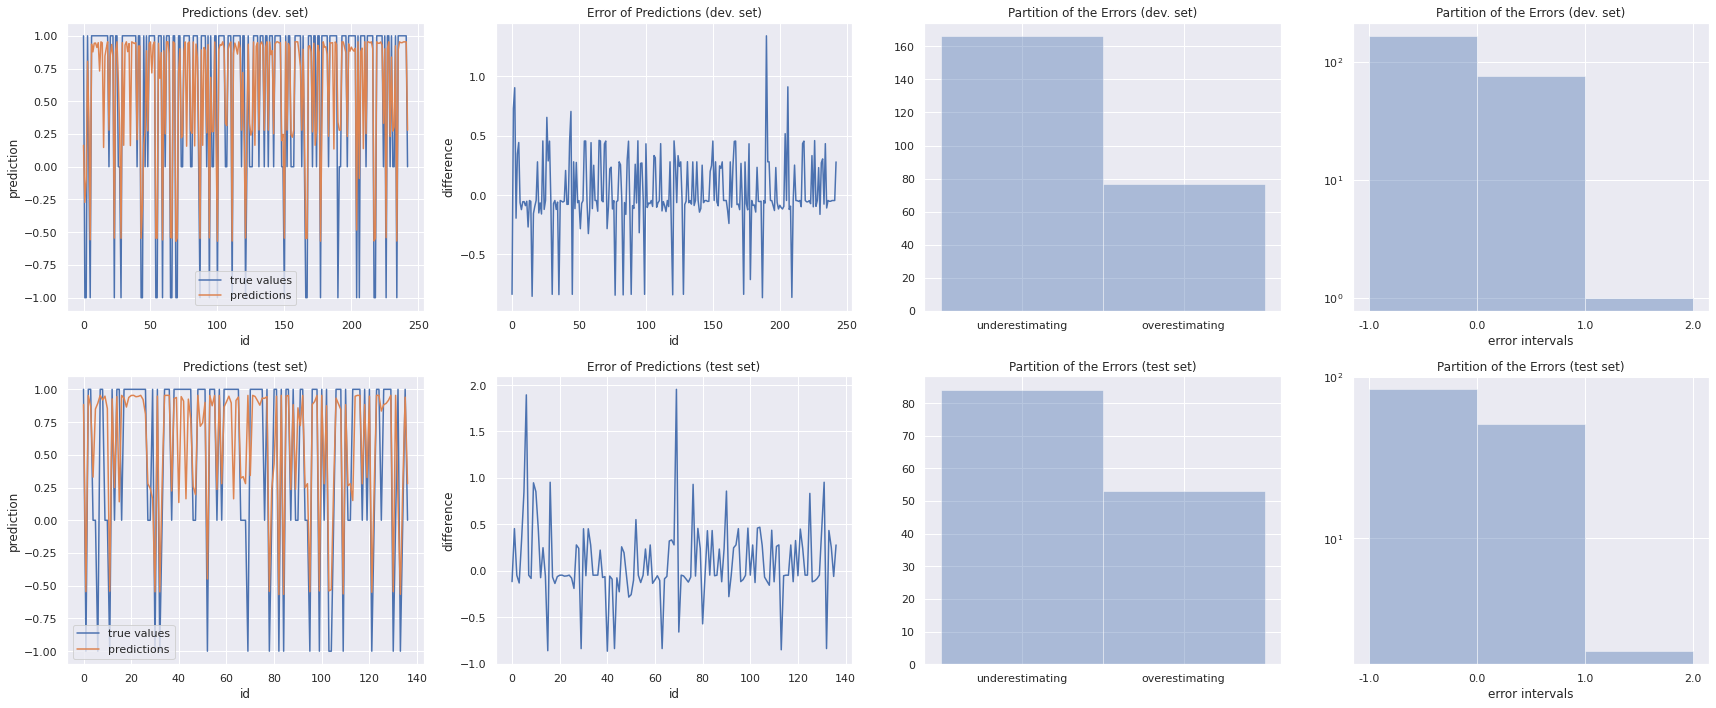

In [63]:
dev_length            = y_dev.shape[0]
test_length           = y_test.shape[0]
ann_model_dev_errors  = ann_model_pred['y_dev_pred'] - y_dev
ann_model_test_errors = ann_model_pred['y_test_pred'] - y_test

nrows = 2
ncols = 4
ann_model_fig, ann_model_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

# plot dev set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = y_dev.reshape(-1,),
             label = 'true values',
             ax    = ann_model_plot[0,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y     = ann_model_pred['y_dev_pred'].reshape(-1,),
             label = 'predictions',
             ax    = ann_model_plot[0,0]
            )
ann_model_plot[0,0].set(title = 'Predictions (dev. set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = dev_length, num = dev_length, endpoint = False, dtype = int),
             y  = ann_model_dev_errors.reshape(-1,),
             ax = ann_model_plot[0,1]
            )
ann_model_plot[0,1].set(title = 'Error of Predictions (dev. set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(ann_model_dev_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = ann_model_plot[0,2]
            )
ann_model_plot[0,2].set(title = 'Partition of the Errors (dev. set)', xticks = [0, 1])
ann_model_plot[0,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(ann_model_dev_errors.min()), np.ceil(ann_model_dev_errors.max()) + n, 1)
sns.distplot(np.digitize(ann_model_dev_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = ann_model_plot[0,3]
            )
ann_model_plot[0,3].set(title = 'Partition of the Errors (dev. set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
ann_model_plot[0,3].set_xticklabels(list(bins(1)))

# plot test set predictions
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = y_test.reshape(-1,),
             label = 'true values',
             ax    = ann_model_plot[1,0]
            )
sns.lineplot(x     = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y     = ann_model_pred['y_test_pred'].reshape(-1,),
             label = 'predictions',
             ax    = ann_model_plot[1,0]
            )
ann_model_plot[1,0].set(title = 'Predictions (test set)', xlabel = 'id', ylabel = 'prediction')

sns.lineplot(x  = np.linspace(start = 0, stop = test_length, num = test_length, endpoint = False, dtype = int),
             y  = ann_model_test_errors.reshape(-1,),
             ax = ann_model_plot[1,1]
            )
ann_model_plot[1,1].set(title = 'Error of Predictions (test set)', xlabel = 'id', ylabel = 'difference')

sns.distplot(np.array(ann_model_test_errors >= 0.0, dtype = int).reshape(-1,),
             bins     = [0, 1, 2],
             hist_kws = {'align': 'left'},
             kde      = False,
             ax       = ann_model_plot[1,2]
            )
ann_model_plot[1,2].set(title = 'Partition of the Errors (test set)', xticks = [0, 1])
ann_model_plot[1,2].set_xticklabels(['underestimating', 'overestimating'])

bins = lambda n: np.arange(np.floor(ann_model_test_errors.min()), np.ceil(ann_model_test_errors.max()) + n, 1)
sns.distplot(np.digitize(ann_model_test_errors, bins = bins(1)).reshape(-1,),
             bins    = range(1, len(bins(1)) + 1),
             kde     = False,
             axlabel = 'error intervals',
             ax      = ann_model_plot[1,3]
            )
ann_model_plot[1,3].set(title = 'Partition of the Errors (test set)', yscale = 'log', xticks = range(1, len(bins(1)) + 1))
ann_model_plot[1,3].set_xticklabels(list(bins(1)))

ann_model_fig.tight_layout()
ann_model_fig.savefig(path.join(IMG_PATH, 'ann_model.pdf'), dpi = 300, format = 'pdf')
ann_model_fig.savefig(path.join(IMG_PATH, 'ann_model.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(ann_model_fig)

# _A Posteriori_ Analysis

From the predictions of the models, it seems that tree based algorithms are the best at the task, while linear models (and linear SVR) usually do not approximate well the data and Gaussian SVR and ANN overfit the development set.

We propose here an analysis of the RF and GBDT using a **SHAP** approach to better understand the factors entering the output of the models:

In [65]:
import shap

rf_exp   = shap.TreeExplainer(rnd_for_model) #------------------ tree explainer for RF
gbdt_exp = shap.TreeExplainer(grd_boost_model) #---------------- tree explainer for GBDT

We then compute the SHAP values for the test slice (the `pandas` version of the `numpy` matrix used for predictions: this also contains the name of the columns):

In [66]:
rf_shap_values = rf_exp.shap_values(test_slice) #--------------- extract Shapley values for RF
gbdt_shap_values = gbdt_exp.shap_values(test_slice) #----------- extract Shapley values for GBDT

Finally we plot the contribution of each feature to the final result of the RF:

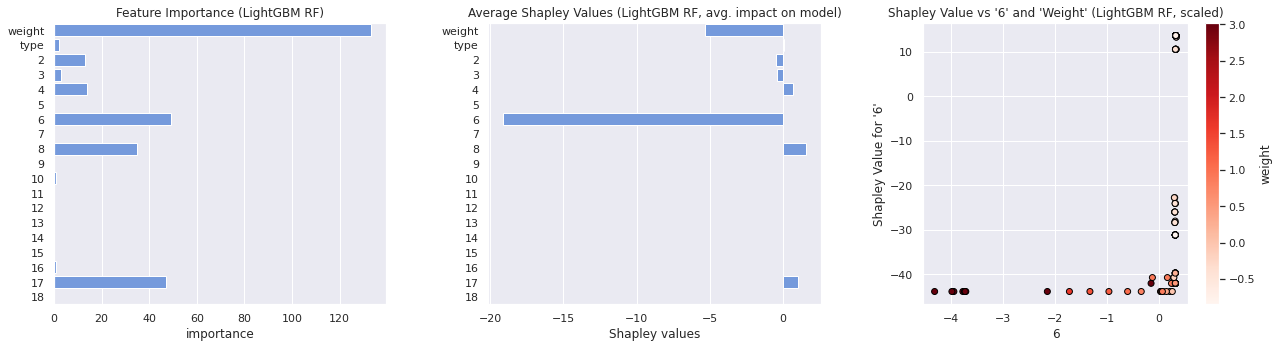

In [72]:
nrows = 1
ncols = 3
rf_shap_fig, rf_shap_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

rf_feat_imp  = {'features':         list(test_slice.columns),
                'tree_importance':  rnd_for_model.feature_importances_.reshape(-1,),
                'shap_values':      rf_shap_values,
                'mean_shap_values': rf_shap_values.mean(axis = 0).reshape(-1,)
               }

sns.barplot(data   = rf_feat_imp,
            x      = 'tree_importance',
            y      = 'features',
            color  = 'cornflowerblue',
            ax     = rf_shap_plot[0]
           )
rf_shap_plot[0].set(title = 'Feature Importance (LightGBM RF)', xlabel = 'importance')

sns.barplot(data   = rf_feat_imp,
            x      = 'mean_shap_values',
            y      = 'features',
            color  = 'cornflowerblue',
            ax     = rf_shap_plot[1]
           )
rf_shap_plot[1].set(title = 'Average Shapley Values (LightGBM RF, avg. impact on model)', xlabel = 'Shapley values')

scatter = rf_shap_plot[2].scatter(x         = x_test[:,6].reshape(-1,),
                                  y         = rf_shap_values[:,6].reshape(-1,),
                                  c         = x_test[:,0].reshape(-1,),
                                  vmin      = x_test[:,0].reshape(-1,).min(),
                                  vmax      = x_test[:,0].reshape(-1,).max(),
                                  cmap      = 'Reds',
                                  edgecolor = 'black'
                                 )
rf_shap_fig.colorbar(scatter, ax = rf_shap_plot[2], label = 'weight')
rf_shap_plot[2].set(title = 'Shapley Value vs \'6\' and \'Weight\' (LightGBM RF, scaled)', xlabel = '6', ylabel = 'Shapley Value for \'6\'')

rf_shap_fig.tight_layout()
rf_shap_fig.savefig(path.join(IMG_PATH, 'rf_shap.pdf'), dpi = 300, format = 'pdf')
rf_shap_fig.savefig(path.join(IMG_PATH, 'rf_shap.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(rf_shap_fig)

We then do the same for the GBDT:

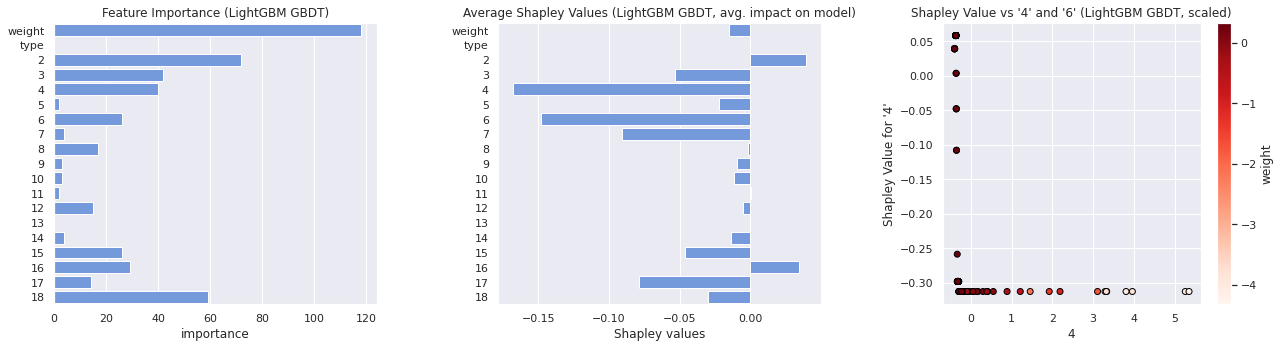

In [76]:
nrows = 1
ncols = 3
gbdt_shap_fig, gbdt_shap_plot = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols * PLT_WIDTH, nrows * PLT_HEIGHT))

gbdt_feat_imp  = {'features':         list(test_slice.columns),
                  'tree_importance':  grd_boost_model.feature_importances_.reshape(-1,),
                  'shap_values':      gbdt_shap_values,
                  'mean_shap_values': gbdt_shap_values.mean(axis = 0).reshape(-1,)
                 }

sns.barplot(data   = gbdt_feat_imp,
            x      = 'tree_importance',
            y      = 'features',
            color  = 'cornflowerblue',
            ax     = gbdt_shap_plot[0]
           )
gbdt_shap_plot[0].set(title = 'Feature Importance (LightGBM GBDT)', xlabel = 'importance')

sns.barplot(data   = gbdt_feat_imp,
            x      = 'mean_shap_values',
            y      = 'features',
            color  = 'cornflowerblue',
            ax     = gbdt_shap_plot[1]
           )
gbdt_shap_plot[1].set(title = 'Average Shapley Values (LightGBM GBDT, avg. impact on model)', xlabel = 'Shapley values')

scatter = gbdt_shap_plot[2].scatter(x         = x_test[:,4].reshape(-1,),
                                    y         = gbdt_shap_values[:,4].reshape(-1,),
                                    c         = x_test[:,6].reshape(-1,),
                                    vmin      = x_test[:,6].reshape(-1,).min(),
                                    vmax      = x_test[:,6].reshape(-1,).max(),
                                    cmap      = 'Reds',
                                    edgecolor = 'black'
                                   )
gbdt_shap_fig.colorbar(scatter, ax = gbdt_shap_plot[2], label = 'weight')
gbdt_shap_plot[2].set(title = 'Shapley Value vs \'4\' and \'6\' (LightGBM GBDT, scaled)', xlabel = '4', ylabel = 'Shapley Value for \'4\'')

gbdt_shap_fig.tight_layout()
gbdt_shap_fig.savefig(path.join(IMG_PATH, 'gbdt_shap.pdf'), dpi = 300, format = 'pdf')
gbdt_shap_fig.savefig(path.join(IMG_PATH, 'gbdt_shap.jpg'), dpi = 300, format = 'jpg', quality = 95, optimize = True, progressive = True)
plt.show()
plt.close(gbdt_shap_fig)

# Output

Finally we save the output predictions and models to file for further use:

In [109]:
# create dataframe for training predictions
df_train_pred = pd.DataFrame({'system':    df_train['system'].values.reshape(-1,),
                              'init':      df_train['init'].values.reshape(-1,),
                              'weight':    df_train['weight'].values.reshape(-1,),
                              'type':      df_train['type'].values.reshape(-1,),
                              'lin_reg':   lin_reg_pred['y_train_pred'].reshape(-1,),
                              'el_net':    el_net_pred['y_train_pred'].reshape(-1,),
                              'lasso':     lasso_pred['y_train_pred'].reshape(-1,),
                              'ridge':     ridge_pred['y_train_pred'].reshape(-1,),
                              'lin_svr':   lin_svr_pred['y_train_pred'].reshape(-1,),
                              'svr_rbf':   svr_rbf_pred['y_train_pred'].reshape(-1,),
                              'rnd_for':   rnd_for_pred['y_train_pred'].reshape(-1,),
                              'grd_boost': grd_boost_pred['y_train_pred'].reshape(-1,),
                              'ann':       ann_model_pred['y_train_pred'].reshape(-1,),
                              'exp':       y_train.reshape(-1,)
                             }, index = df_train.index).sort_index(ignore_index = True)

# create dataframe for validation predictions
df_dev_pred   = pd.DataFrame({'system':    df_dev['system'].values.reshape(-1,),
                              'init':      df_dev['init'].values.reshape(-1,),
                              'weight':    df_dev['weight'].values.reshape(-1,),
                              'type':      df_dev['type'].values.reshape(-1,),
                              'lin_reg':   lin_reg_pred['y_dev_pred'].reshape(-1,),
                              'el_net':    el_net_pred['y_dev_pred'].reshape(-1,),
                              'lasso':     lasso_pred['y_dev_pred'].reshape(-1,),
                              'ridge':     ridge_pred['y_dev_pred'].reshape(-1,),
                              'lin_svr':   lin_svr_pred['y_dev_pred'].reshape(-1,),
                              'svr_rbf':   svr_rbf_pred['y_dev_pred'].reshape(-1,),
                              'rnd_for':   rnd_for_pred['y_dev_pred'].reshape(-1,),
                              'grd_boost': grd_boost_pred['y_dev_pred'].reshape(-1,),
                              'ann':       ann_model_pred['y_dev_pred'].reshape(-1,),
                              'exp':       y_dev.reshape(-1,)
                             }, index = df_dev.index).sort_index(ignore_index = True)

# create dataframe for test predictions
df_test_pred  = pd.DataFrame({'system':    df_test['system'].values.reshape(-1,),
                              'init':      df_test['init'].values.reshape(-1,),
                              'weight':    df_test['weight'].values.reshape(-1,),
                              'type':      df_test['type'].values.reshape(-1,),
                              'lin_reg':   lin_reg_pred['y_test_pred'].reshape(-1,),
                              'el_net':    el_net_pred['y_test_pred'].reshape(-1,),
                              'lasso':     lasso_pred['y_test_pred'].reshape(-1,),
                              'ridge':     ridge_pred['y_test_pred'].reshape(-1,),
                              'lin_svr':   lin_svr_pred['y_test_pred'].reshape(-1,),
                              'svr_rbf':   svr_rbf_pred['y_test_pred'].reshape(-1,),
                              'rnd_for':   rnd_for_pred['y_test_pred'].reshape(-1,),
                              'grd_boost': grd_boost_pred['y_test_pred'].reshape(-1,),
                              'ann':       ann_model_pred['y_test_pred'].reshape(-1,),
                              'exp':       y_test.reshape(-1,),
                             }, index = df_test.index).sort_index(ignore_index = True)
# save predictions to CSV file
fp_train = path.join(DAT_PATH, 'sft-data_train-set_pred.csv')
df_train_pred.to_csv(fp_train, index = False)

fp_dev   = path.join(DAT_PATH, 'sft-data_dev-set_pred.csv')
df_dev_pred.to_csv(fp_dev, index = False)

fp_test  = path.join(DAT_PATH, 'sft-data_test-set_pred.csv')
df_test_pred.to_csv(fp_test, index = False)

log.debug('Predictions saved to file.')

We also save the values of the hyperparameters used:

In [104]:
import json

with open(path.join(OUT_PATH, 'lin_reg_params.json'), 'w') as f:
    json.dump({f: str(lin_reg_params[f]) for f in lin_reg_params}, f) #-------------------------- save LR
    
with open(path.join(OUT_PATH, 'el_net_params.json'), 'w') as f:
    json.dump({f: str(el_net_params[f]) for f in el_net_params}, f) #---------------------------- save EN
    
with open(path.join(OUT_PATH, 'lasso_params.json'), 'w') as f:
    json.dump({f: str(lasso_params[f]) for f in lasso_params}, f) #------------------------------ save LASSO
    
with open(path.join(OUT_PATH, 'ridge_params.json'), 'w') as f:
    json.dump({f: str(ridge_params[f]) for f in ridge_params}, f) #------------------------------ save RIDGE
    
with open(path.join(OUT_PATH, 'lin_svr_params.json'), 'w') as f:
    json.dump({f: str(lin_svr_params[f]) for f in lin_svr_params}, f) #-------------------------- save LSVR
    
with open(path.join(OUT_PATH, 'svr_rbf_params.json'), 'w') as f:
    json.dump({f: str(svr_rbf_params[f]) for f in svr_rbf_params}, f) #-------------------------- save SVR
    
with open(path.join(OUT_PATH, 'rnd_for_params.json'), 'w') as f:
    json.dump({f: str(rnd_for_params[f]) for f in rnd_for_params}, f) #-------------------------- save RF
    
with open(path.join(OUT_PATH, 'grd_boost_params.json'), 'w') as f:
    json.dump({f: str(grd_boost_params[f]) for f in grd_boost_params}, f) #---------------------- save BDT
    
with open(path.join(OUT_PATH, 'ann_params.json'), 'w') as f:
    json.dump({f: str(ann_params[f]) for f in ann_params}, f) #---------------------------------- save ANN
    
log.debug('Parameters saved to file.')

NameError: name 'ann_params' is not defined

Finally we save all the fitted models:

In [105]:
import joblib, json

joblib.dump(lin_reg_model,   path.join(MOD_PATH, 'lin_reg.pkl.xz'),   compress = ('xz', 9)) #---------- save LR
joblib.dump(el_net_model,    path.join(MOD_PATH, 'el_net.pkl.xz'),    compress = ('xz', 9)) #---------- save EN
joblib.dump(lasso_model,     path.join(MOD_PATH, 'lasso.pkl.xz'),     compress = ('xz', 9)) #---------- save LASSO
joblib.dump(ridge_model,     path.join(MOD_PATH, 'ridge.pkl.xz'),     compress = ('xz', 9)) #---------- save RIDGE
joblib.dump(lin_svr_model,   path.join(MOD_PATH, 'lin_svr.pkl.xz'),   compress = ('xz', 9)) #---------- save LSVR
joblib.dump(svr_rbf_model,   path.join(MOD_PATH, 'svr_rbf.pkl.xz'),   compress = ('xz', 9)) #---------- save SVR
joblib.dump(rnd_for_model,   path.join(MOD_PATH, 'rnd_for.pkl.xz'),   compress = ('xz', 9)) #---------- save RF
joblib.dump(grd_boost_model, path.join(MOD_PATH, 'grd_boost.pkl.xz'), compress = ('xz', 9)) #---------- save BDt
    
# We separately save the architecture  of ANN to JSON and the weights to file
with open(path.join(MOD_PATH, 'ann_model_architecture.json'), 'w') as f: #----------------------------- save ANN architecture
    json.dump(json.loads(ann_model.to_json()), f)

joblib.dump(ann_model.get_weights(),
            path.join(MOD_PATH, 'ann_model_weights.pkl.xz'),
            compress = ('xz', 9)
           ) #----------------------------------------------------------------------------------------- save ANN weights in Pickle format
ann_model.save_weights(path.join(MOD_PATH, 'ann_model_weights.h5')) #---------------------------------- save ANN weights in HDF5 format

log.debug('Models saved to file.')